# Classifier I

In [1]:
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/shreyam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Fetching the data

Data: https://ia800107.us.archive.org/27/items/stackexchange/stackoverflow.com-Posts.7z

### Extracting and Filtering data

In [2]:
import os
import re
from collections import defaultdict
from tqdm.notebook import tqdm
import ujson as json

In [3]:
DATA_DIR = r"data"

YEAR = 2017

fn_posts_all = os.path.join(DATA_DIR, "Posts.xml")
fn_posts = os.path.join(DATA_DIR, f"posts-{YEAR}.xml")

fn_filtered = os.path.join(DATA_DIR, f"filtered-{YEAR}.tsv")
fn_filtered_meta = os.path.join(DATA_DIR, f"filtered-{YEAR}-meta.json")

SAMPLE_DIR = str(YEAR)
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)
    
if not os.path.exists(os.path.join(SAMPLE_DIR, "data")):
    os.mkdir(os.path.join(SAMPLE_DIR, "data"))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, "data", "sample.tsv"))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, "data", "sample-meta.json"))
print(f"sample posts: {fn_sample}")
print(f"sample meta: {fn_sample_meta}")


sample posts: /home/shreyam/Downloads/repos/active/machine-learning-assignments/Assignment05/2017/data/sample.tsv
sample meta: /home/shreyam/Downloads/repos/active/machine-learning-assignments/Assignment05/2017/data/sample-meta.json


In [4]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)
print(size)

62688472336


In [5]:
def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))

In [6]:
print(f"Extracting all posts from {YEAR}")
with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
    if os.path.exists(fn_posts):
        pass
    else:
        # first two lines are xml header and <posts> tag
        f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')

        right = size // 2
        delta = right

        # first find some post of YEAR
        while True:
            fa.seek(right)
            fa.readline()  # go to next newline
            line = fa.readline()

            year = get_year(line)

            delta //= 2
            assert delta > 0

            if year > YEAR:
                right -= delta
            elif year < YEAR:
                right += delta
            else:
                break

        # then find where it starts
        left = right // 2
        delta = left
        while True:
            fa.seek(left)
            fa.readline() # go to next new line
            line = fa.readline()

            year = get_year(line)

            delta //= 2
            if delta == 0:
                break

            if year < YEAR:
                left += delta
            else:
                left, right = left-delta, left

        # finally, write all posts of that year
        while True:
            line = fa.readline()
            year = get_year(line)
            if year == YEAR:
                f_year.write(line)
            elif year is None or year > YEAR:
                break

        # At last, write the closing tag
        f_year.write("</posts>")

print(".................done")


Extracting all posts from 2017
.................done


In [7]:
from dateutil import parser as dateparser

from operator import itemgetter
from lxml import etree

NUM_ROWS = 5113519 # counted by hand

filtered_meta = {
    'question': {}, # question -> [(answer Id, Score), ...]
    'total': 0 # questions and answers finally written
}

# Regular expressions to find code snippets, links, and tags, which might help in 
# designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count

num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    # iterparse() returns a tuple (event, element). Since we request only
    # 'start' events, we pipe the result through an itemgetter that always returns
    # the 2nd result.
    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount = extract_features_from_body(elem.get('Body'))

        # We have to tell lxml that this element is not used anymore. Otherwise, memory will blow up.
        # See https://www.ibm.com/developerworks/xml/library/x-hiperfparse for more information.
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text)

        yield values

    print("Found %i posts" % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#qestions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % fn_filtered_meta)
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

Skipping the conversion step, loading data from data/filtered-2017-meta.json ...
... done!


In [8]:
NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

# Sorting the questions before iterating over them is only done for
# reproducability.
for ParentId, posts in tqdm(sorted(question.items()), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if found_questions >= NUM_QUESTION_SAMPLE:
        break

Stage 1::   0%|          | 0/2399762 [00:00<?, ?it/s]

In [10]:
already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_sample, "w", encoding='utf-8') as f:
    for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)

Stage 2::   0%|          | 0/5113519 [00:00<?, ?it/s]

read: 4951648
kept: 30000


### Utility functions

In [12]:
def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

meta = load_meta(fn_sample_meta)

### Defining what a good answer is

In [13]:
all_answers = [a for a, v in meta.items() if v['ParentId'] != -1]

Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))

(array([False,  True]), array([10000, 10000]))


### Creating our first classifier: kNN using only LinkCount as a feature

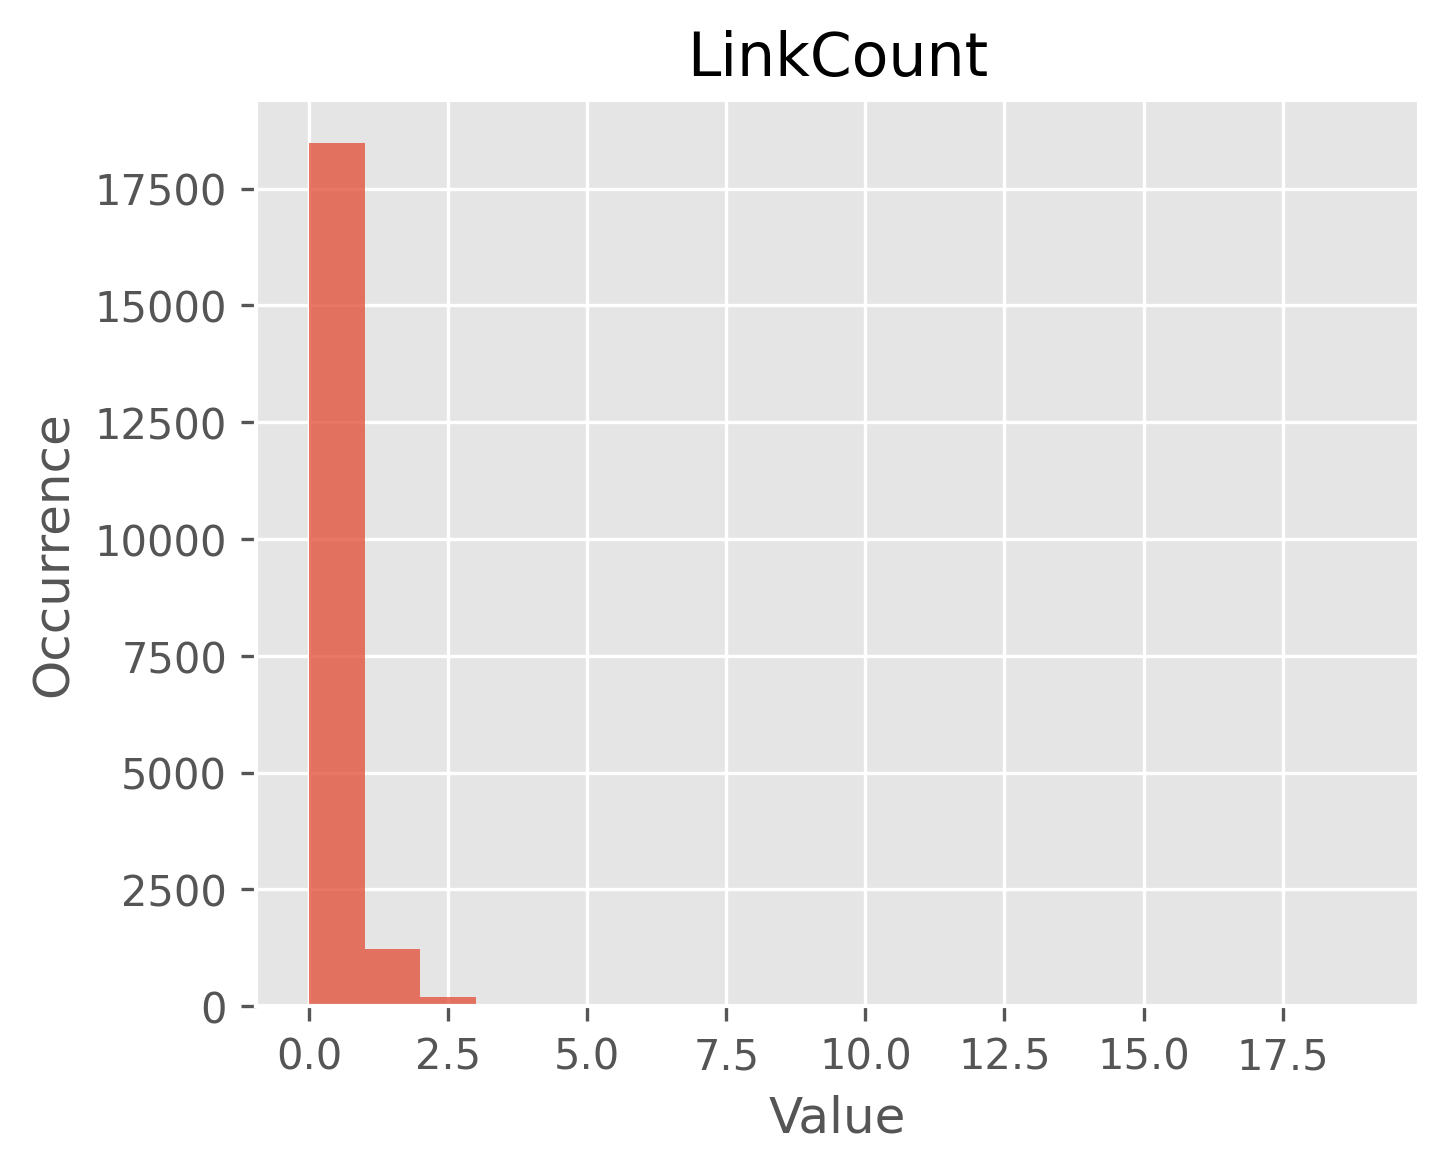

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=300) # width and height of the plot in inches

plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurrence')

n, bins, patches = plt.hist(X, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)

### Training on LinkCount

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

scores = []
for train, test in tqdm(cv.split(X, Y)):
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print(f"Mean(scores)={round(np.mean(scores),5)}\tStddev(scores)={round(np.std(scores),5)}")

0it [00:00, ?it/s]

Mean(scores)=0.49165	Stddev(scores)=0.01269


### Using more features

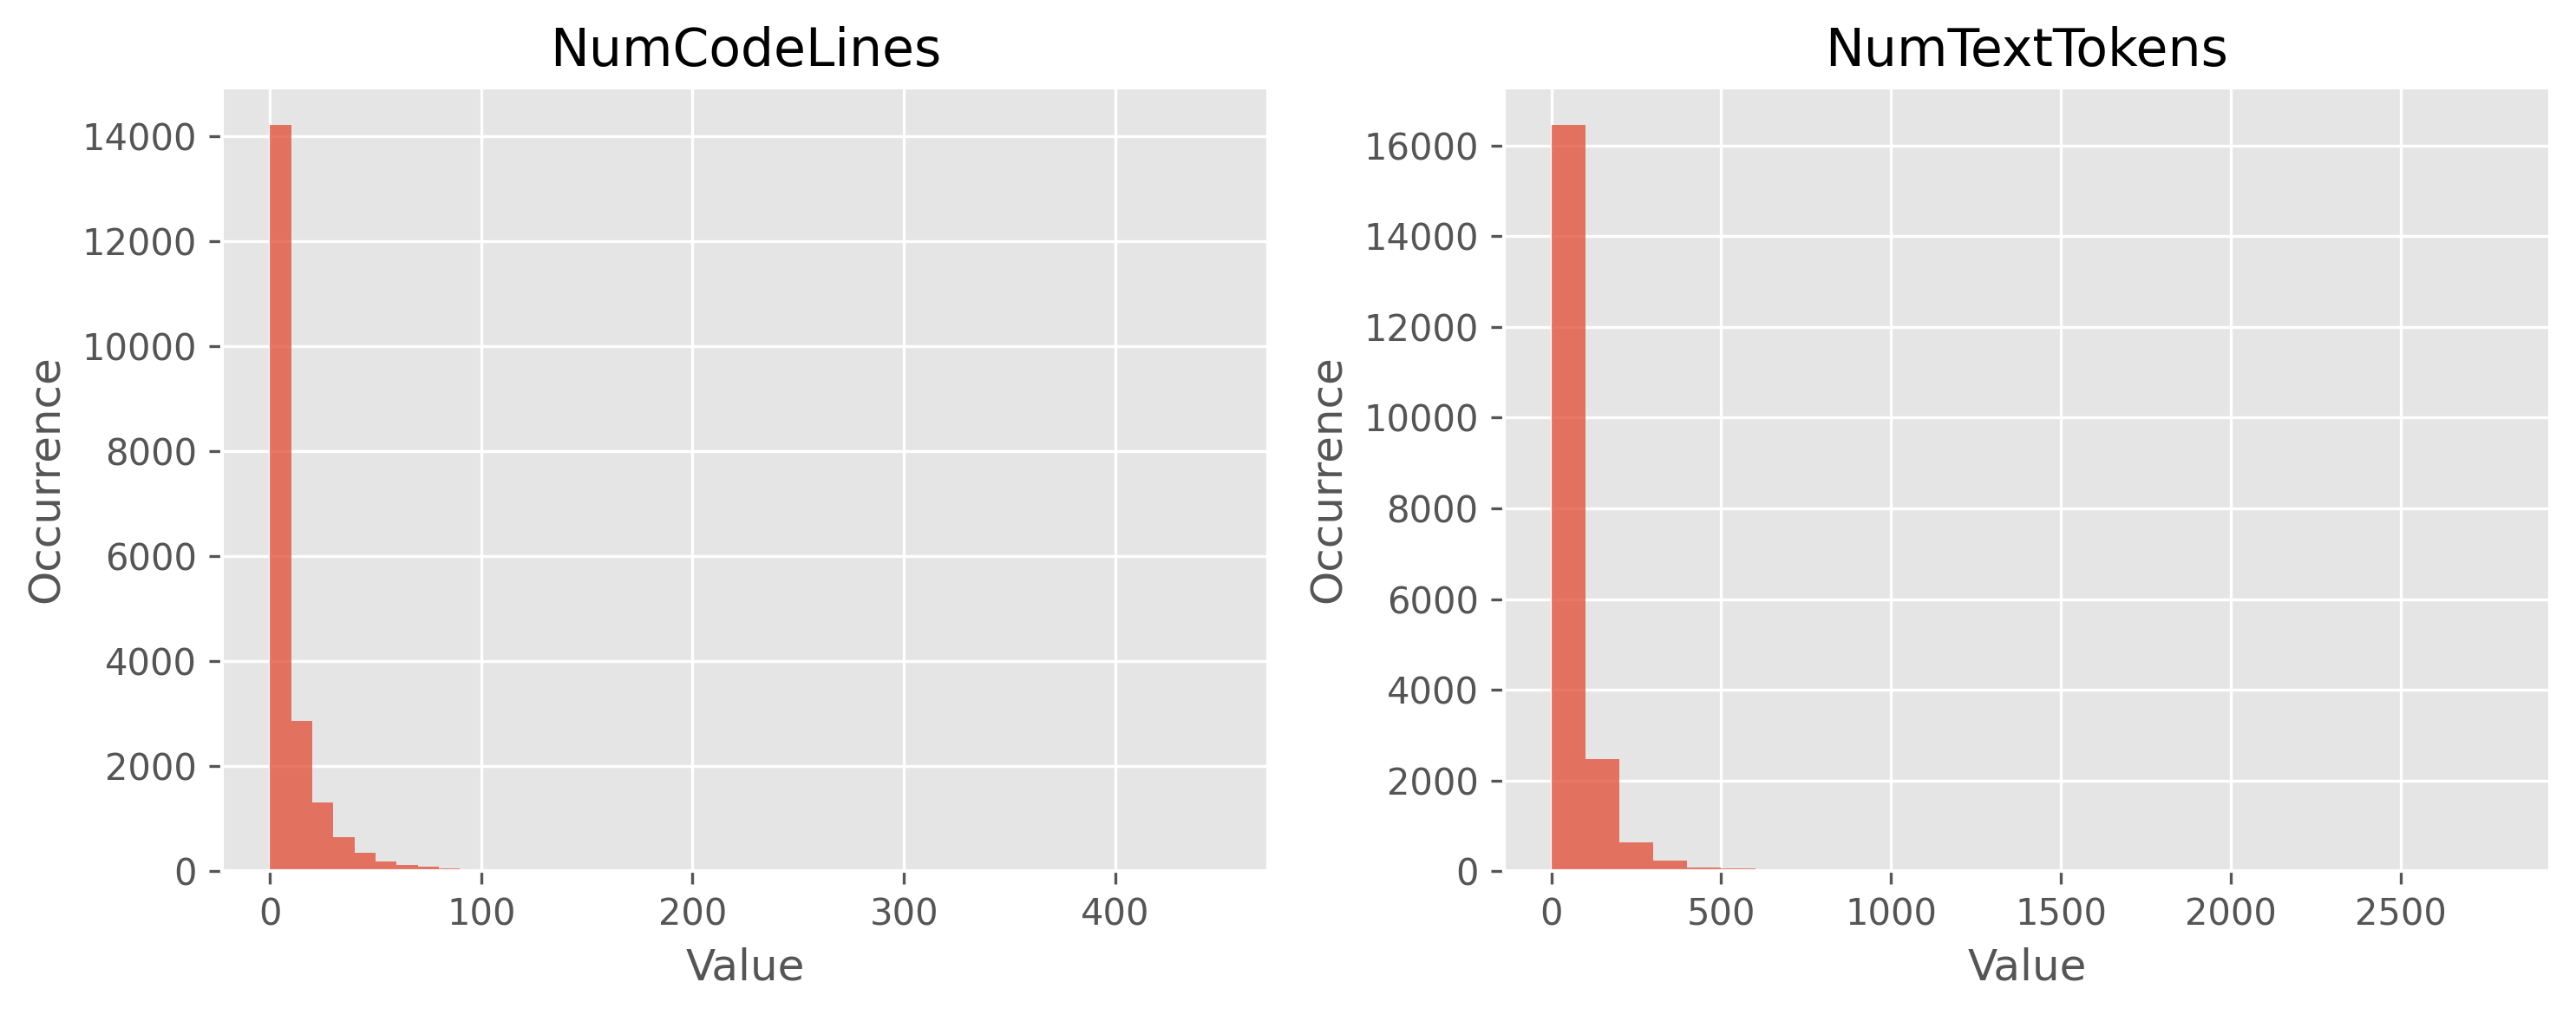

In [16]:
def plot_feat_hist(data_name_list):
    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()


plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')])

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print(f"Mean(scores)={round(np.mean(scores),5)}\tStddev(scores)={round(np.std(scores),5)}") 

  0%|          | 0/10 [00:00<?, ?it/s]

Mean(scores)=0.60045	Stddev(scores)=0.01062


### Designing more features

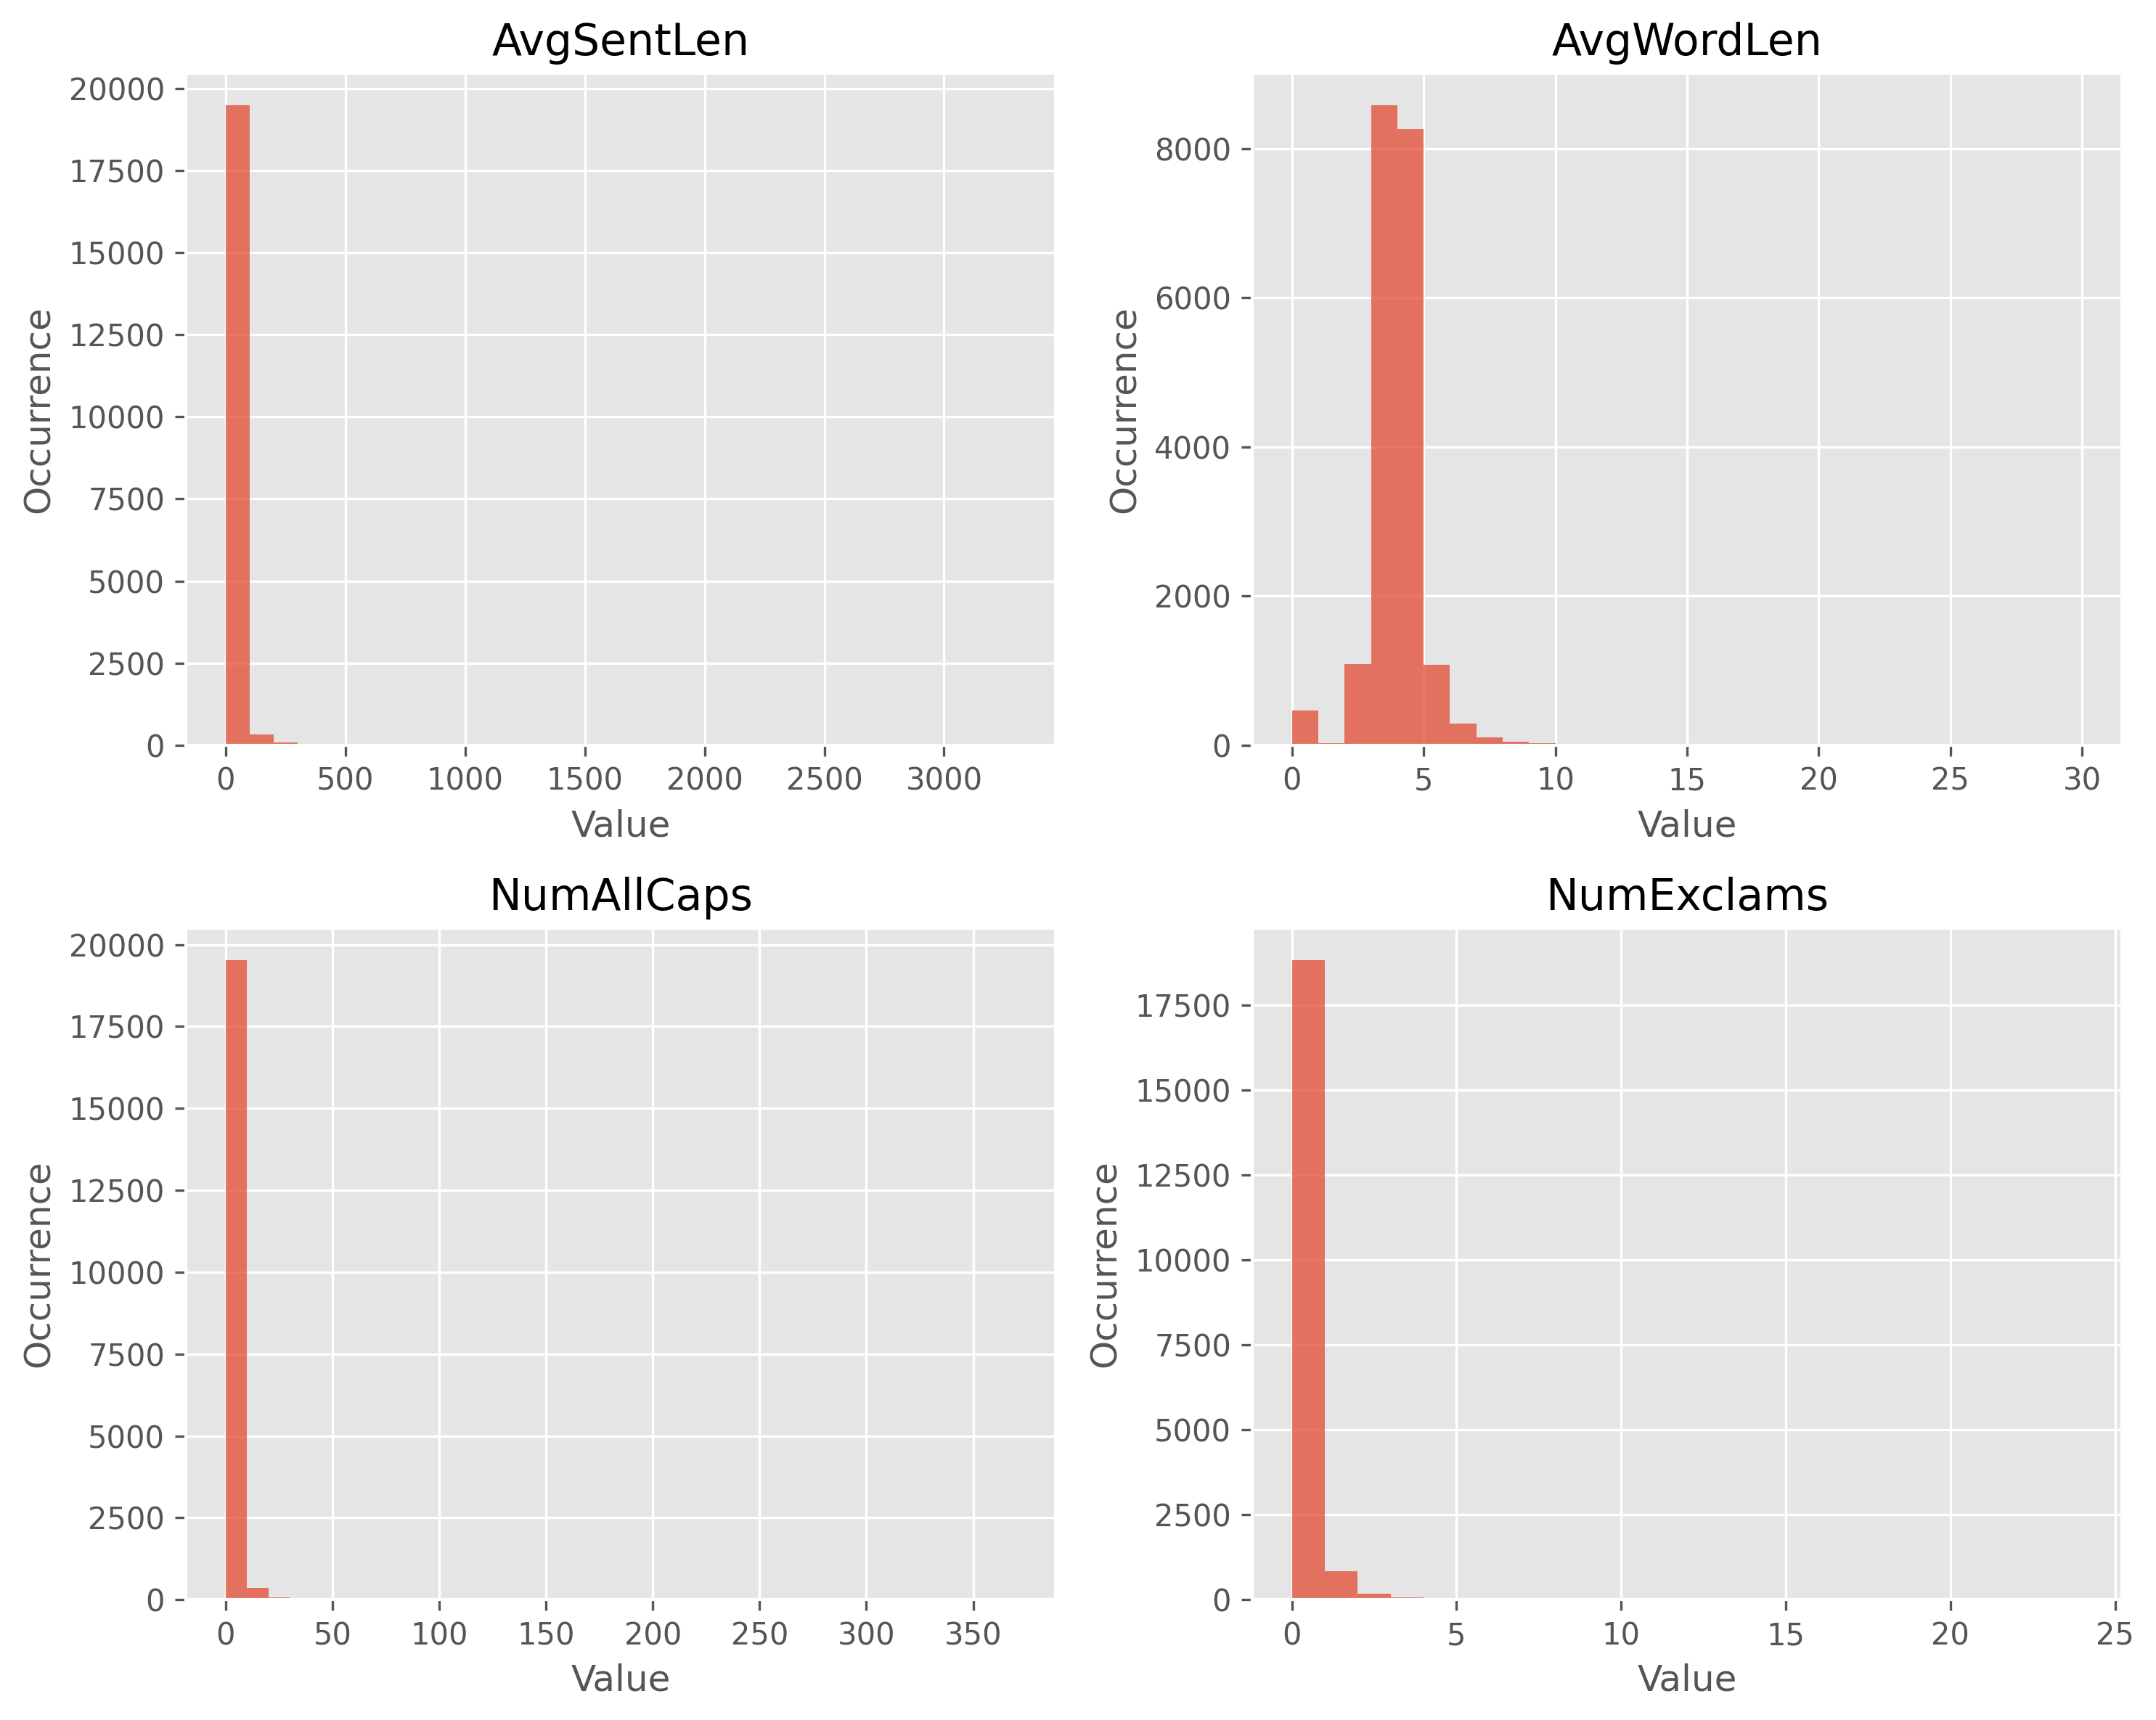

In [18]:
import nltk

def fetch_posts(fn):
    for line in open(fn, 'r', encoding='utf-8'):
        post_id, text = line.split('\t')
        yield int(post_id), text.strip()

def add_sentence_features(m):
    for pid, text in fetch_posts(fn_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']])

In [19]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):    
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print(f"Mean(scores)={round(np.mean(scores),5)}\tStddev(scores)={round(np.std(scores),5)}") 

  0%|          | 0/10 [00:00<?, ?it/s]

Mean(scores)=0.605	Stddev(scores)=0.01061


### Bias-variance and their tradeoff

In [20]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title(f"Bias-Variance for '{name}'")
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'P/R (AUC={round(auc_score, 2)}) / {label}')
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)

    plt.title(f"Feature importance for {name.split('_')[-1]}")
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        if False:
            print(f"Clone #{fold_idx}")
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], plot + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {'name': name,
               'scores': scores,
               'roc_scores': roc_scores,
               'pr_scores': pr_scores,
               'med_precisions': precisions[medium], 
               'med_recalls': recalls[medium], 
               'med_thresholds': thresholds[medium]}
    
    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, f"Bias-Variance for '{name}'")

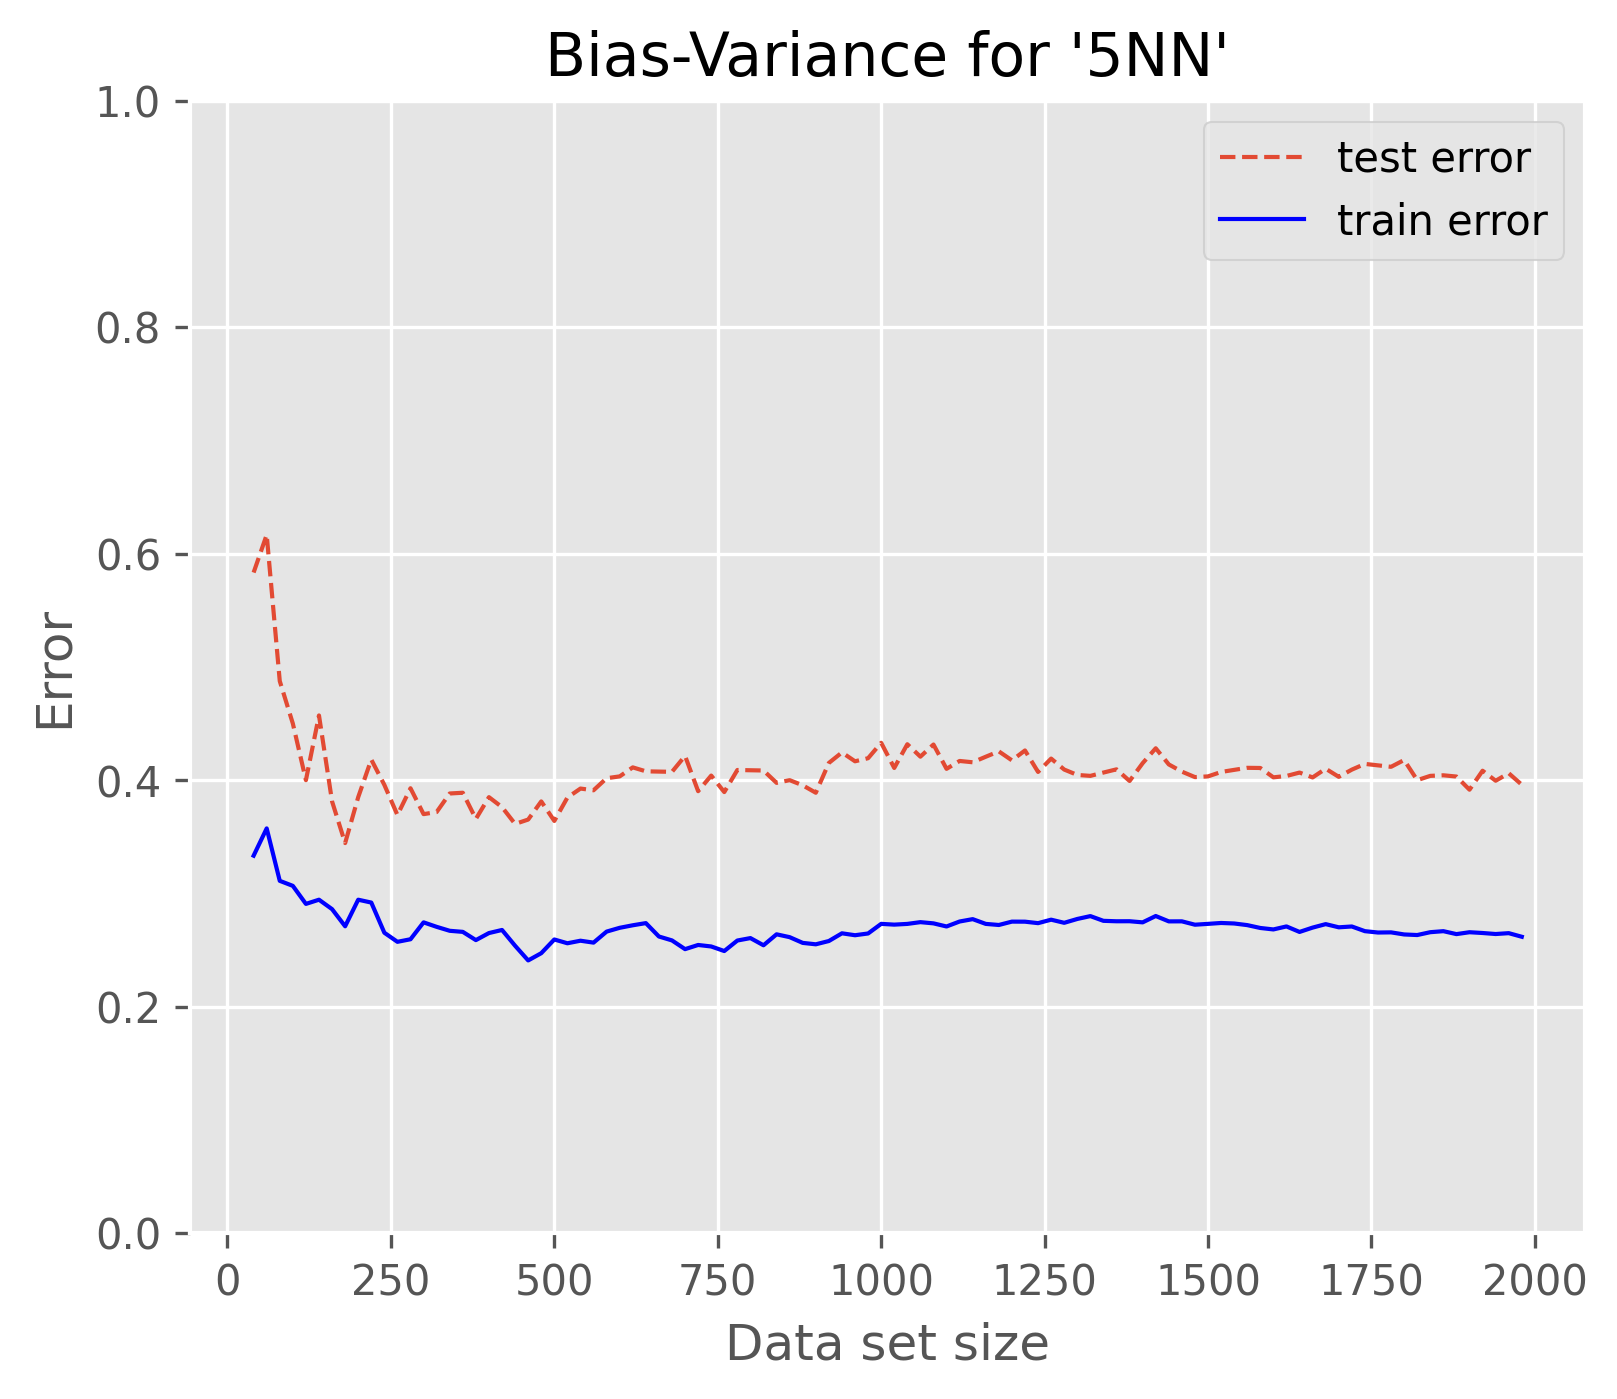

In [21]:
def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)

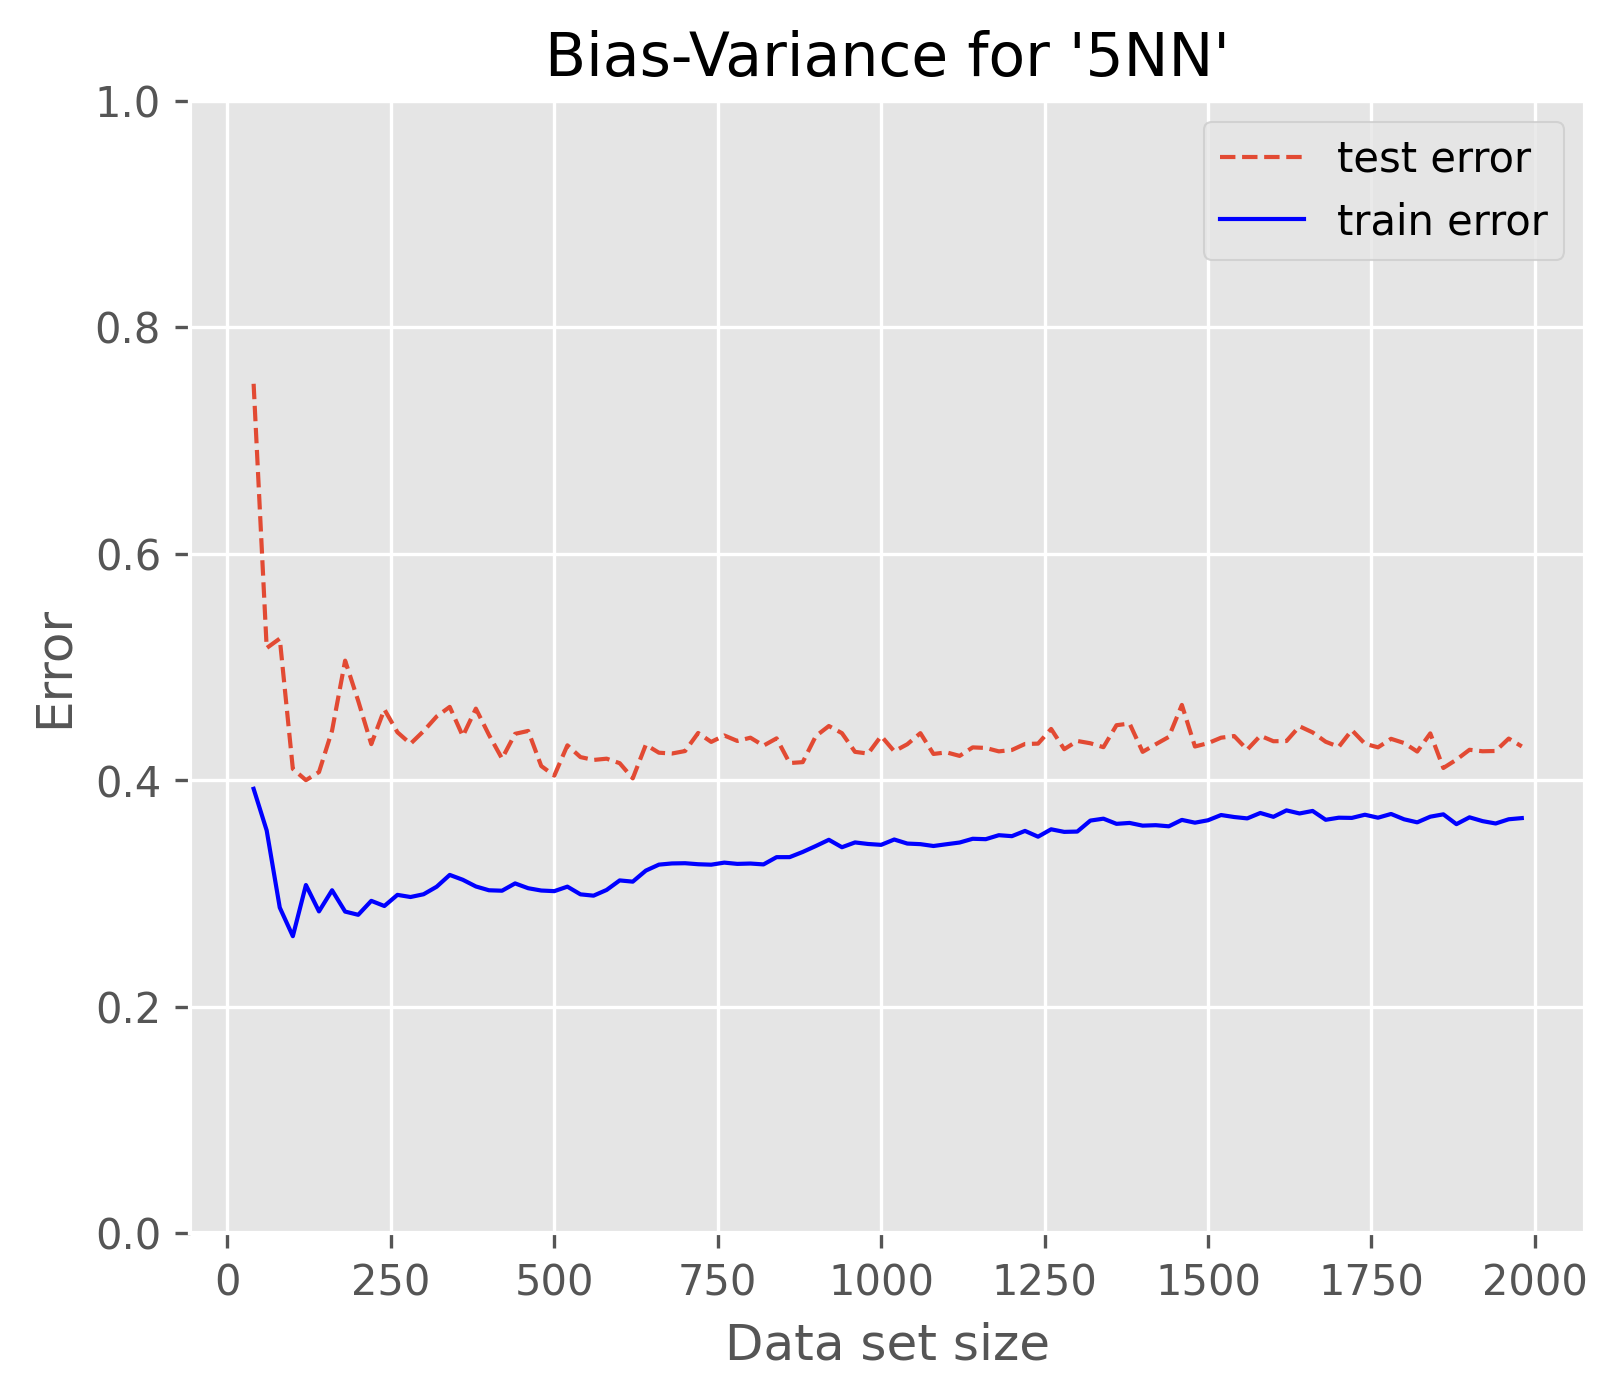

In [22]:
from sklearn.utils import shuffle
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)

In [23]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, f"{k}NN", X, Y)
    print(f"{k}\t{round(np.mean(summary['scores']),4)}\t\t{round(np.std(summary['scores']),4)}")

k	mean(scores)	stddev(scores)
5	0.605		0.0106
10	0.6193		0.0073
40	0.6398		0.0111


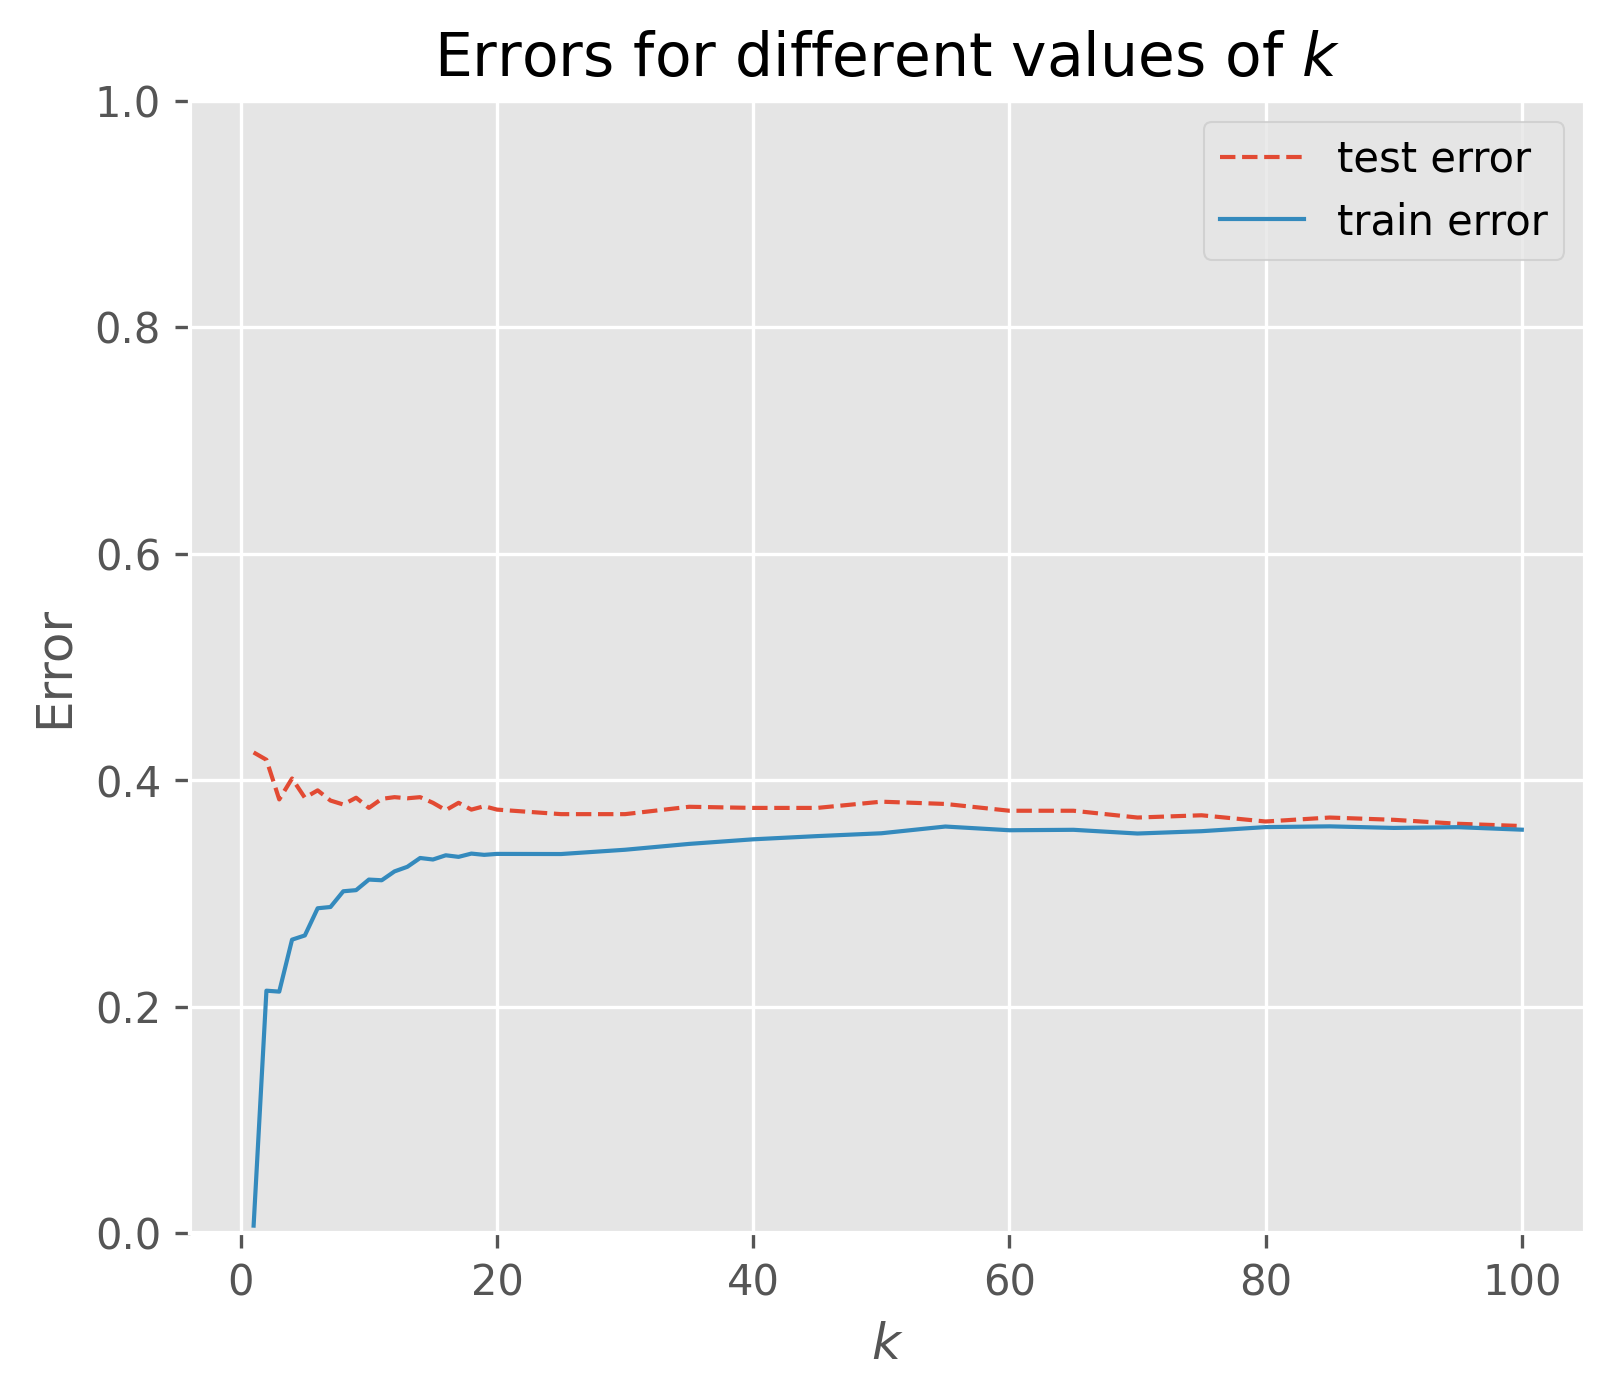

In [25]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


k_complexity_analysis(create_pipeline, X, Y)    

### Using logistic regression

Text(0, 0.5, 'Class')

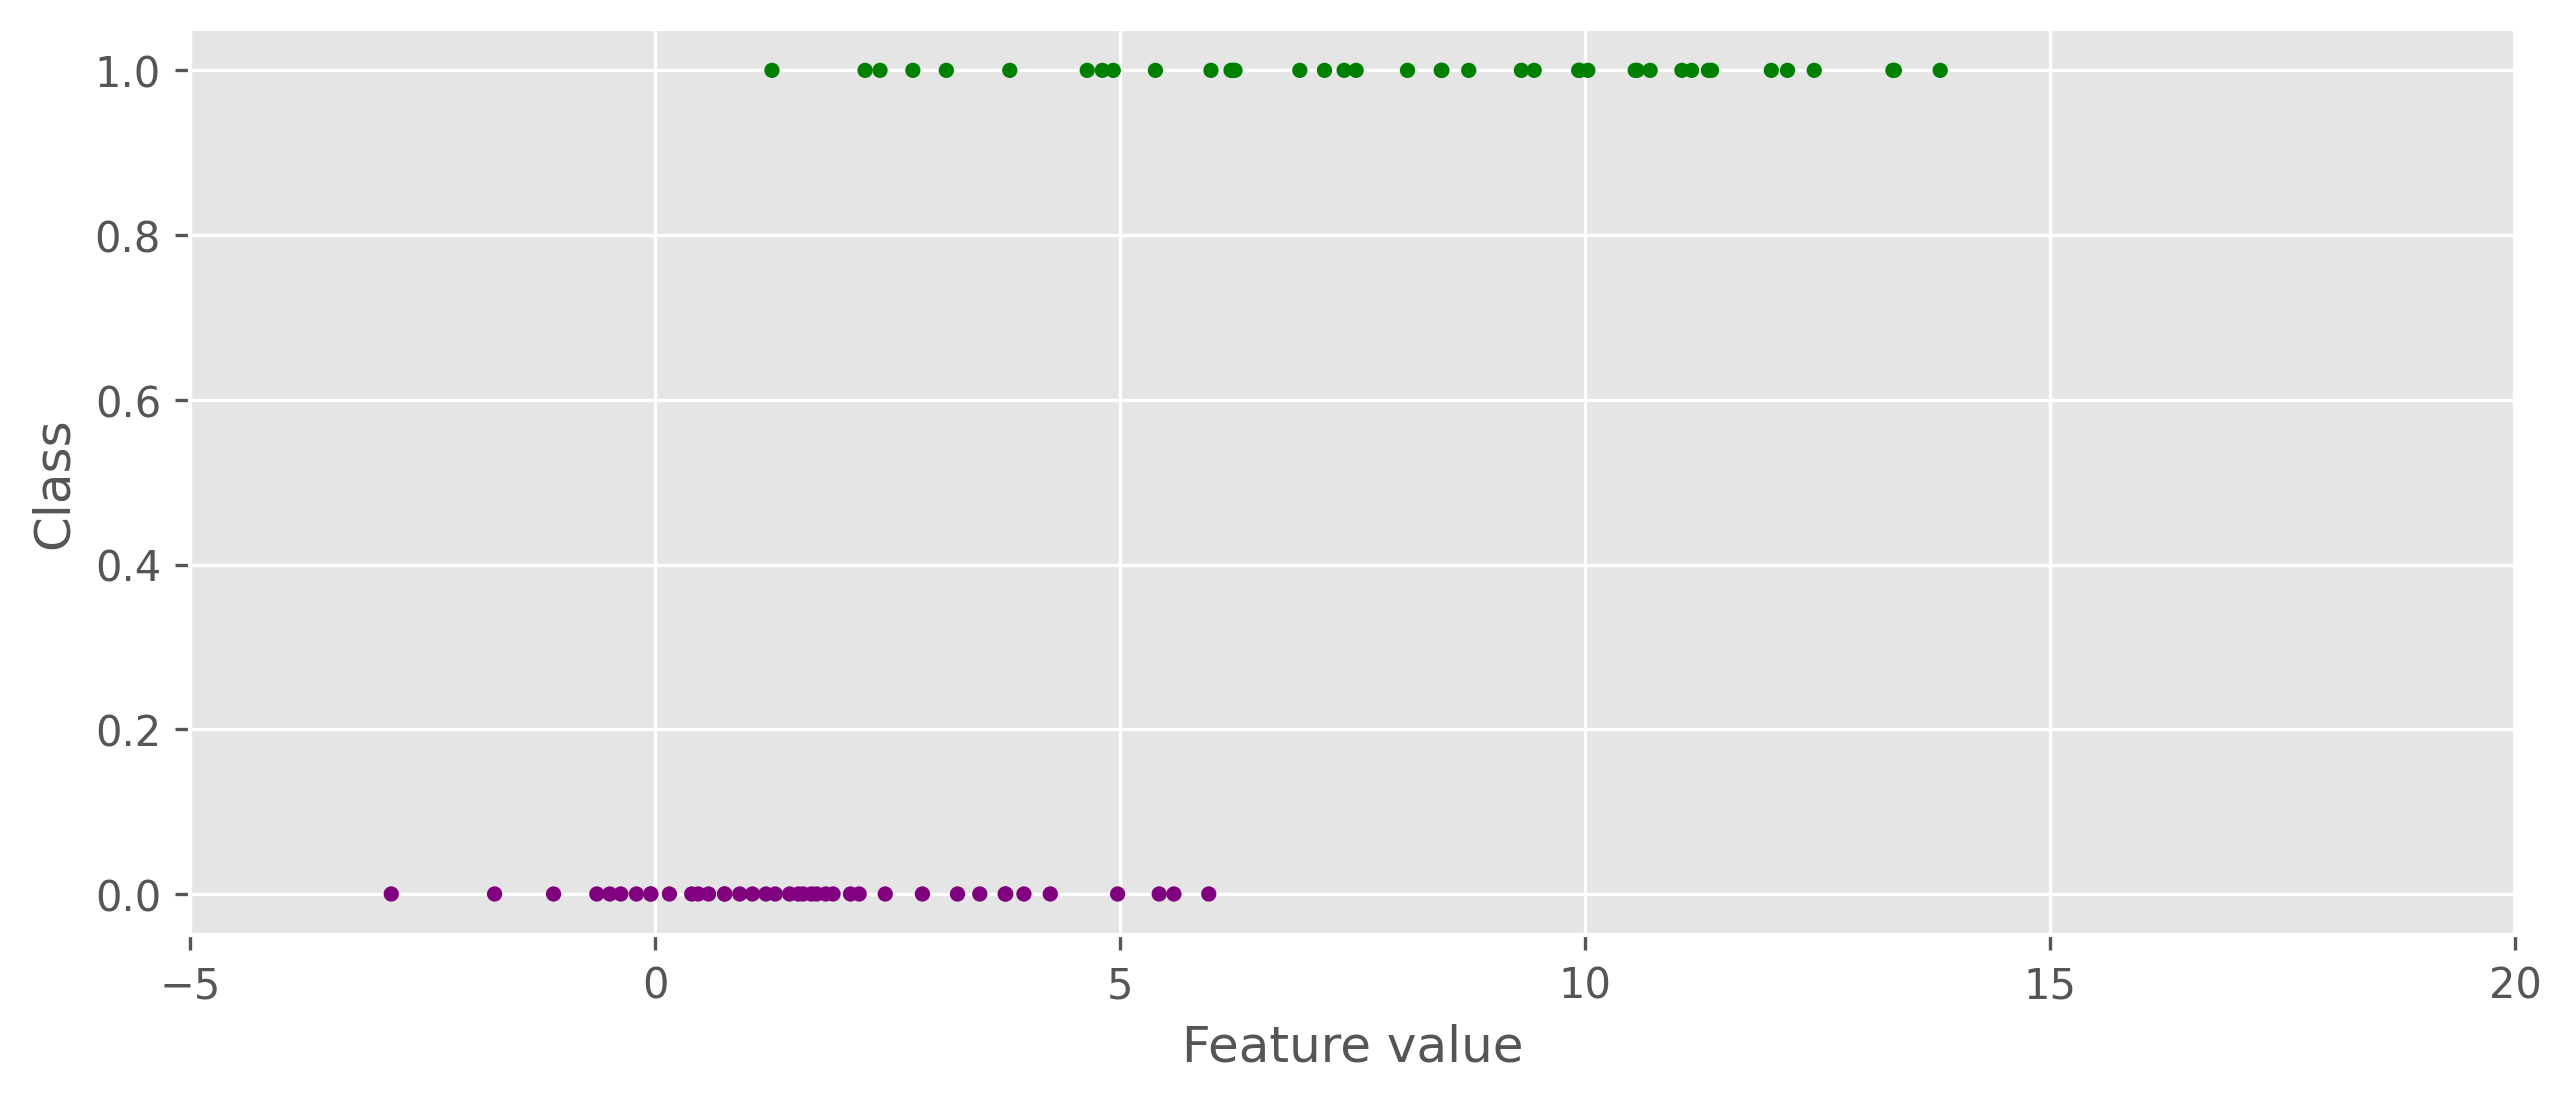

In [27]:
from scipy.stats import norm

np.random.seed(3)

NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2), norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS), np.ones(NUM_PER_CLASS))).astype(int)

plt.figure(figsize=(10, 4), dpi=300)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['purple', 'green'])[y_log], s=10)
plt.xlabel("Feature value")
plt.ylabel("Class")

In [28]:
from sklearn.linear_model import LogisticRegression

def lr_model(clf, X):
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print(f"P(x=-1)={round(float(lr_model(logclf, -1)), 2)}\tP(x=7)={round(float(lr_model(logclf, 7)), 2)}")

[0.03518544] [2.17570283]
P(x=-1)=0.02	P(x=7)=0.89


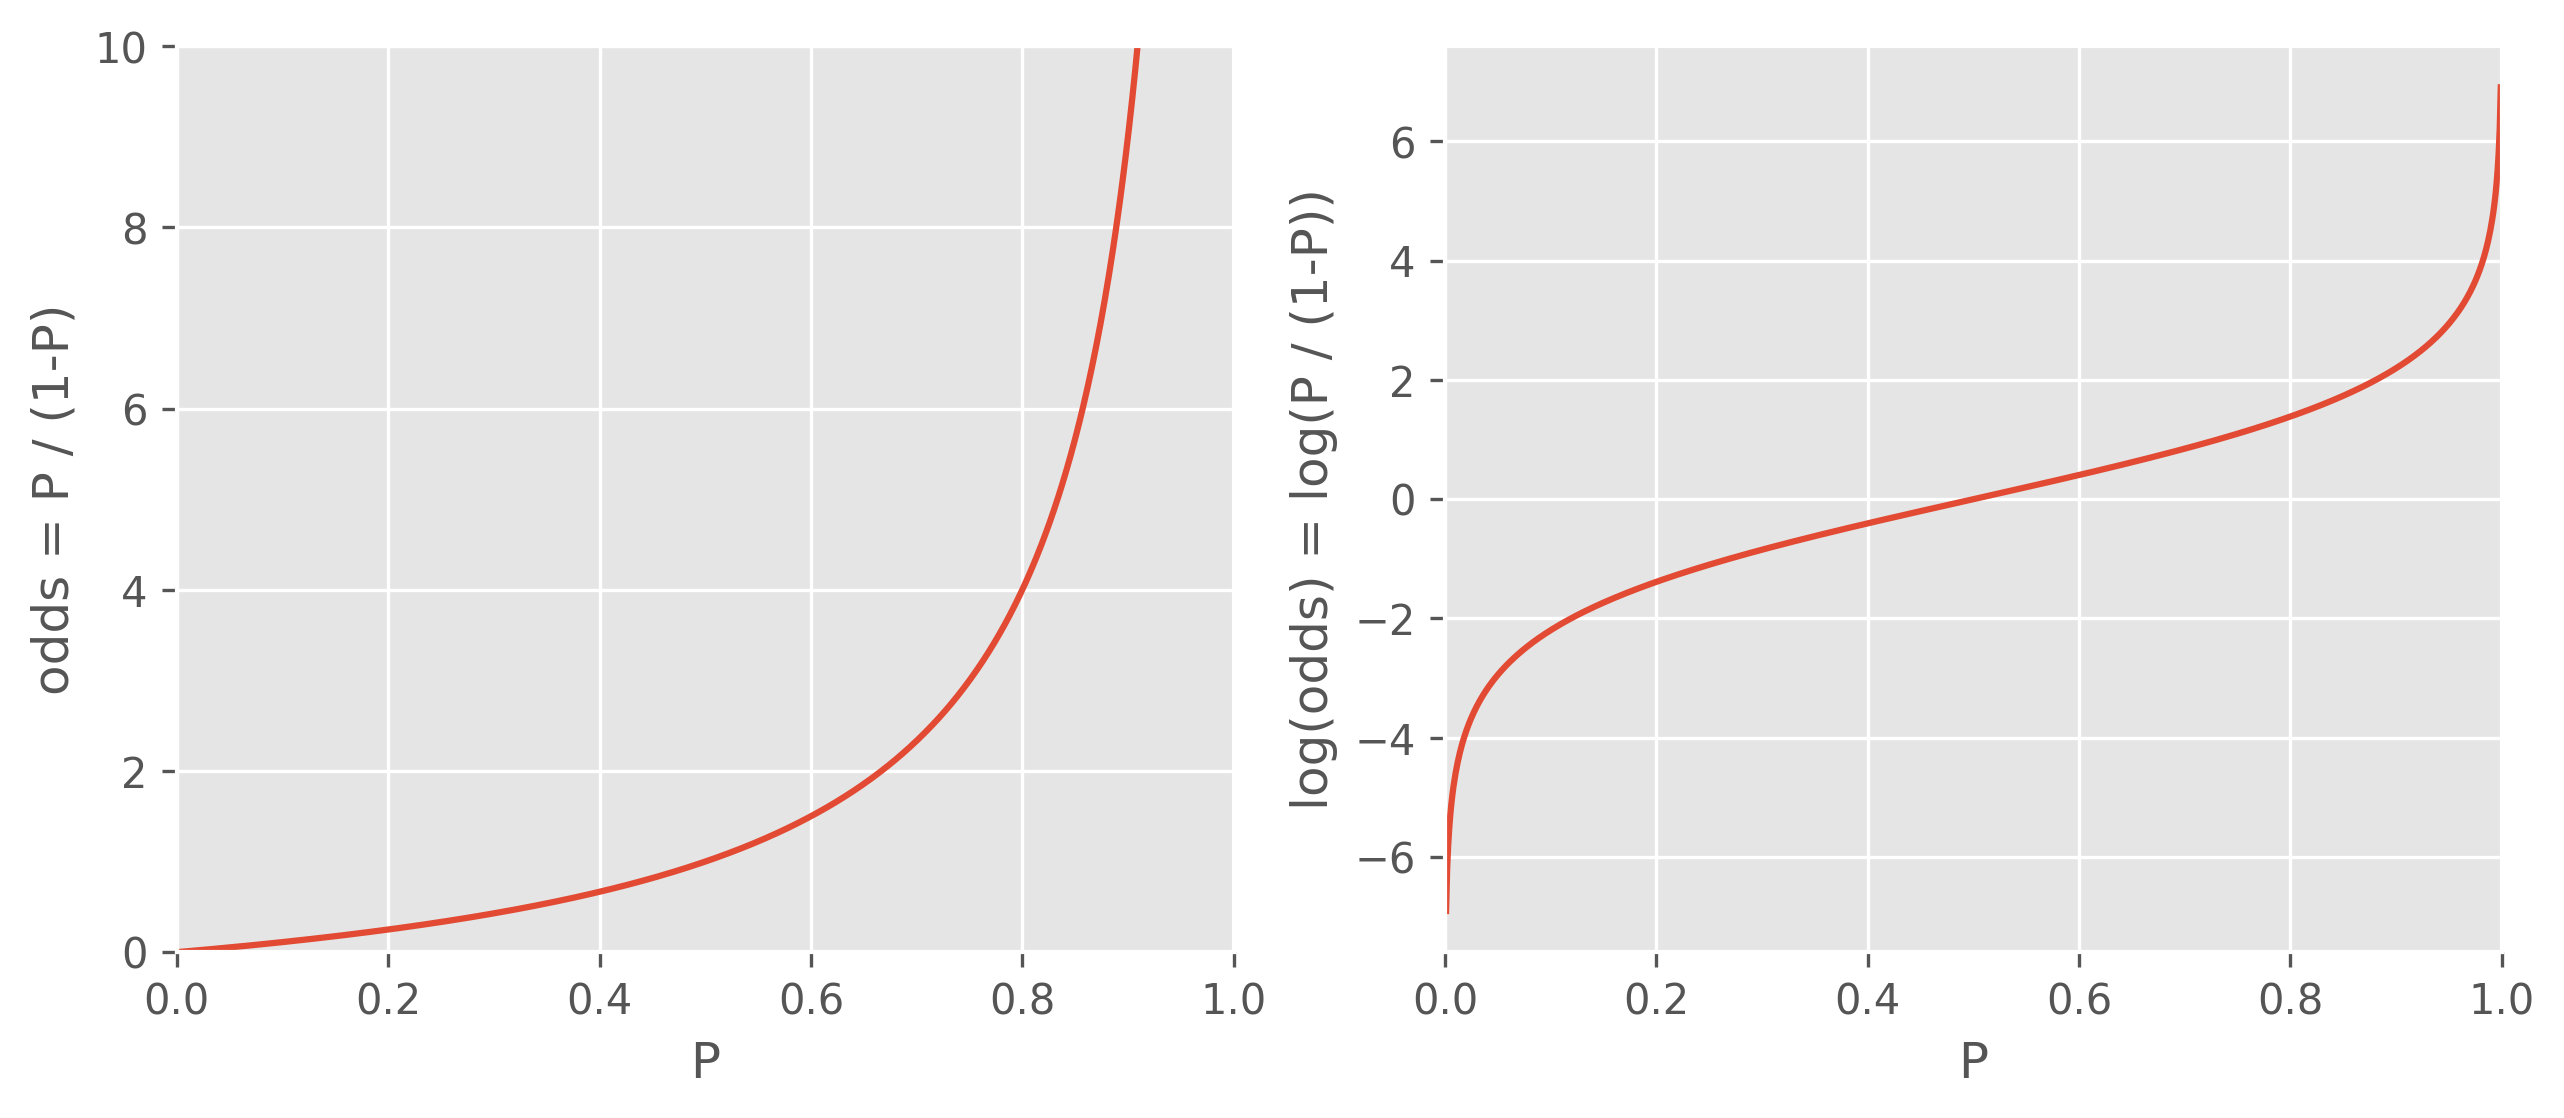

In [29]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)

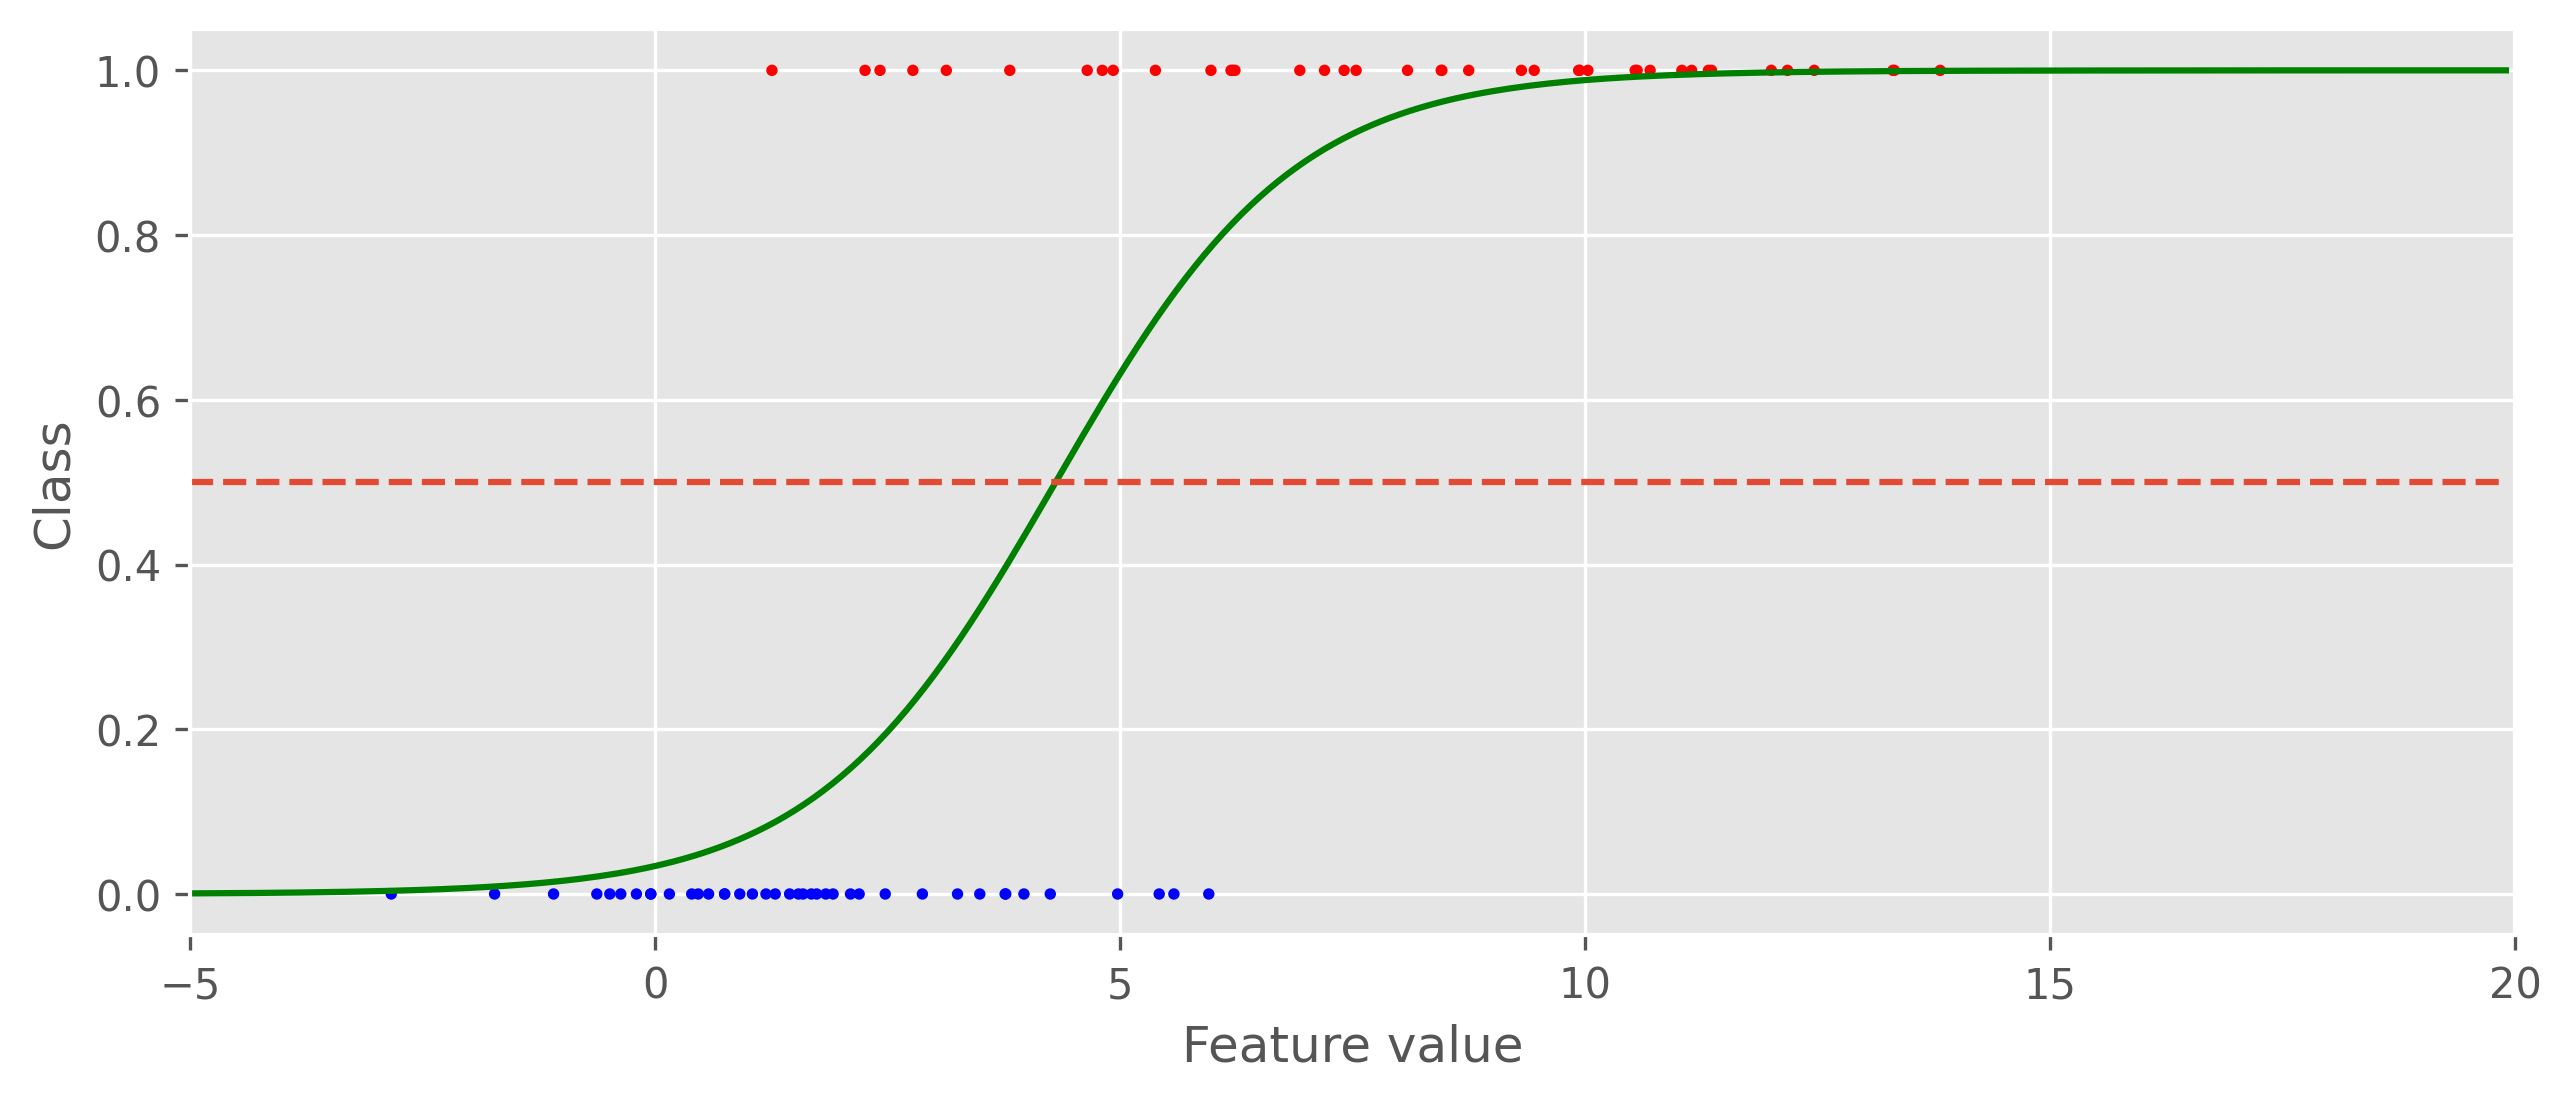

In [30]:
X_range = np.arange(-5, 20, 0.1)

plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
plt.plot(X_range, lr_model(logclf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("Feature value")
plt.ylabel("Class")
plt.grid(True)

### Applying logistic regression to our post classification problem

In [31]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = f"LogReg C={round(C,2)}"
    _, _, summary = measure(LogisticRegression, {'C': C}, name, X, Y)

    print(f"{round(C, 4)}\t{round(np.mean(summary['scores']),4)}\t\t{round(np.std(summary['scores']),4)}")

C	mean(scores)	stddev(scores)
0.001	0.6388		0.0088


/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.01	0.6388		0.0082


/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.1	0.6385		0.0077


/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

1.0	0.6385		0.0081


/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10.0	0.6384		0.0079


/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
C_best = 0.001

### Looking behind accuracy - precision and recall

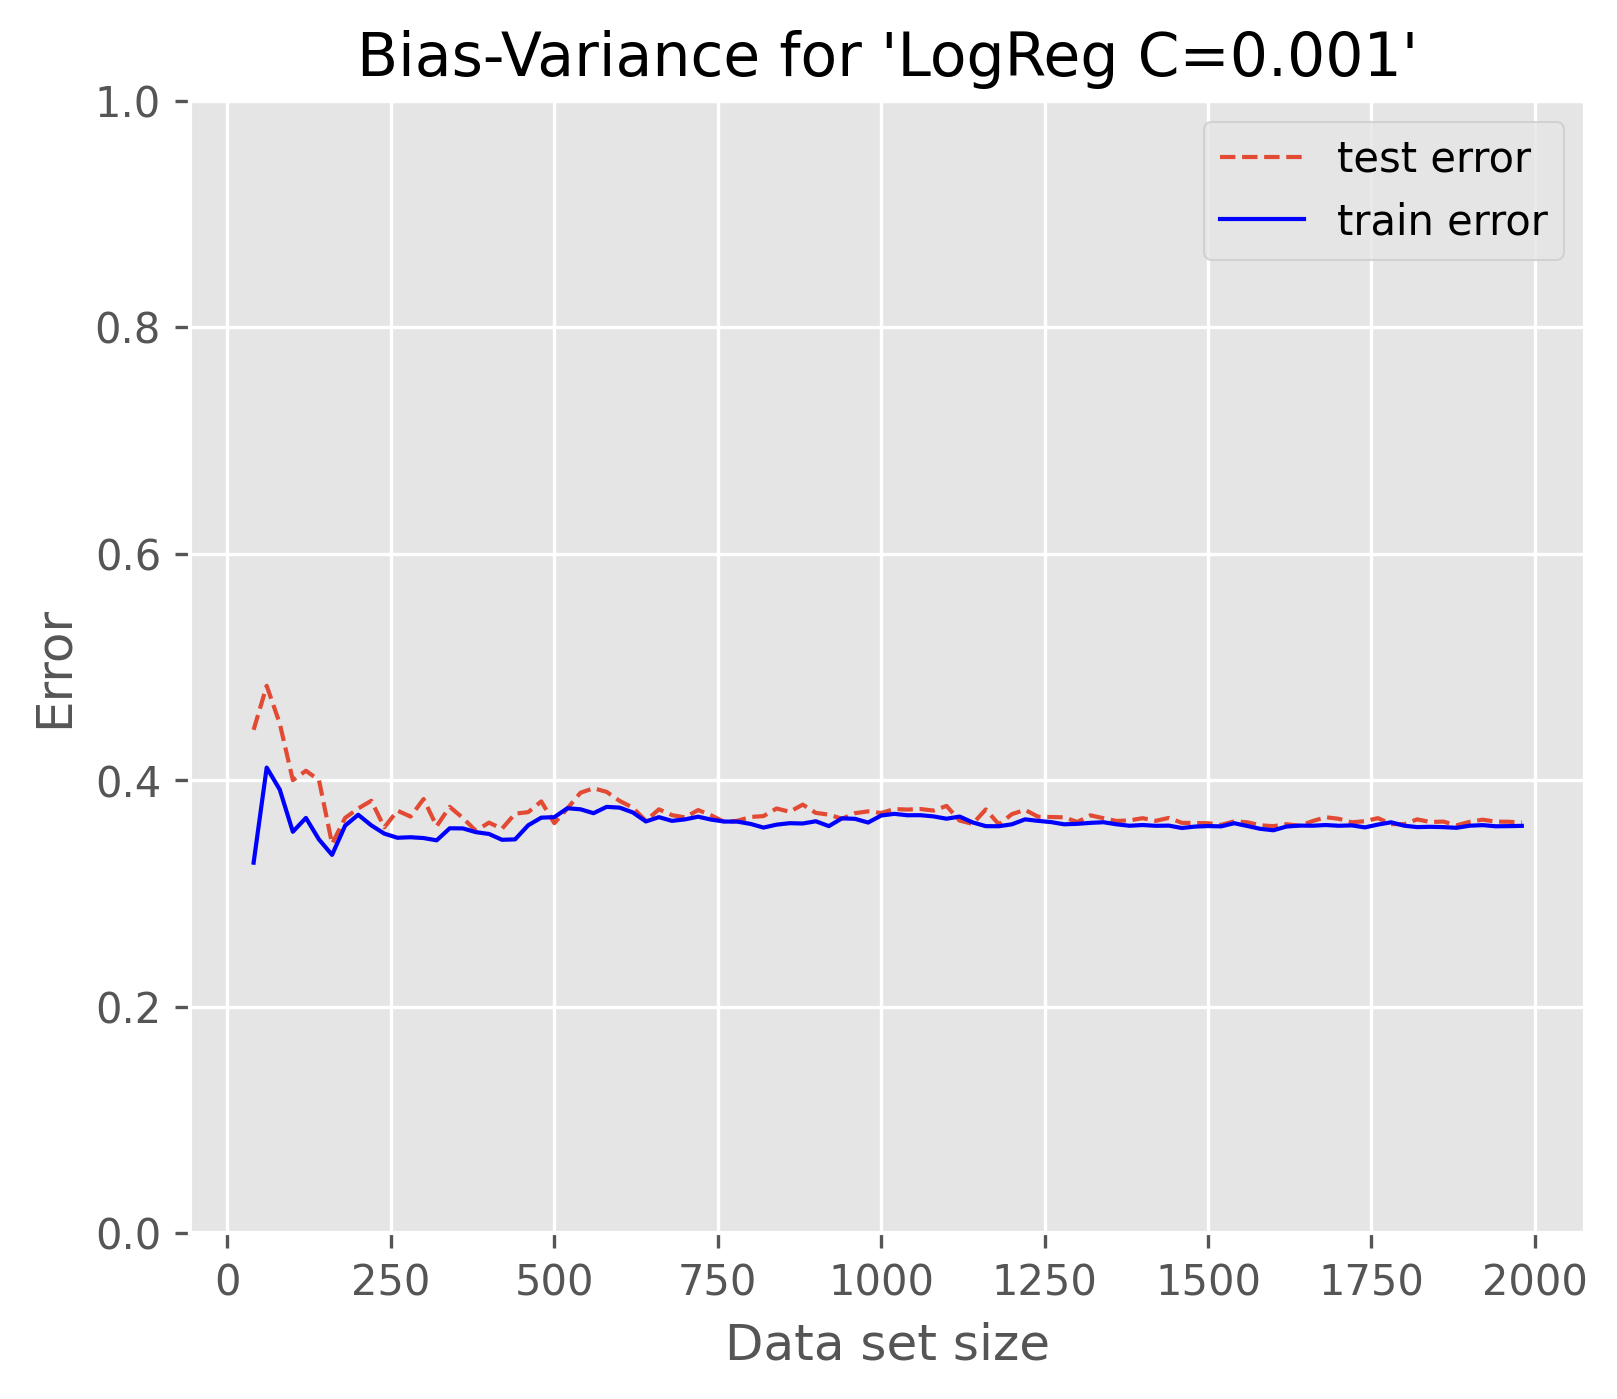

In [33]:
bias_variance_analysis(LogisticRegression, {'C': C_best}, "LogReg C=0.001", X, Y)

Good answers...


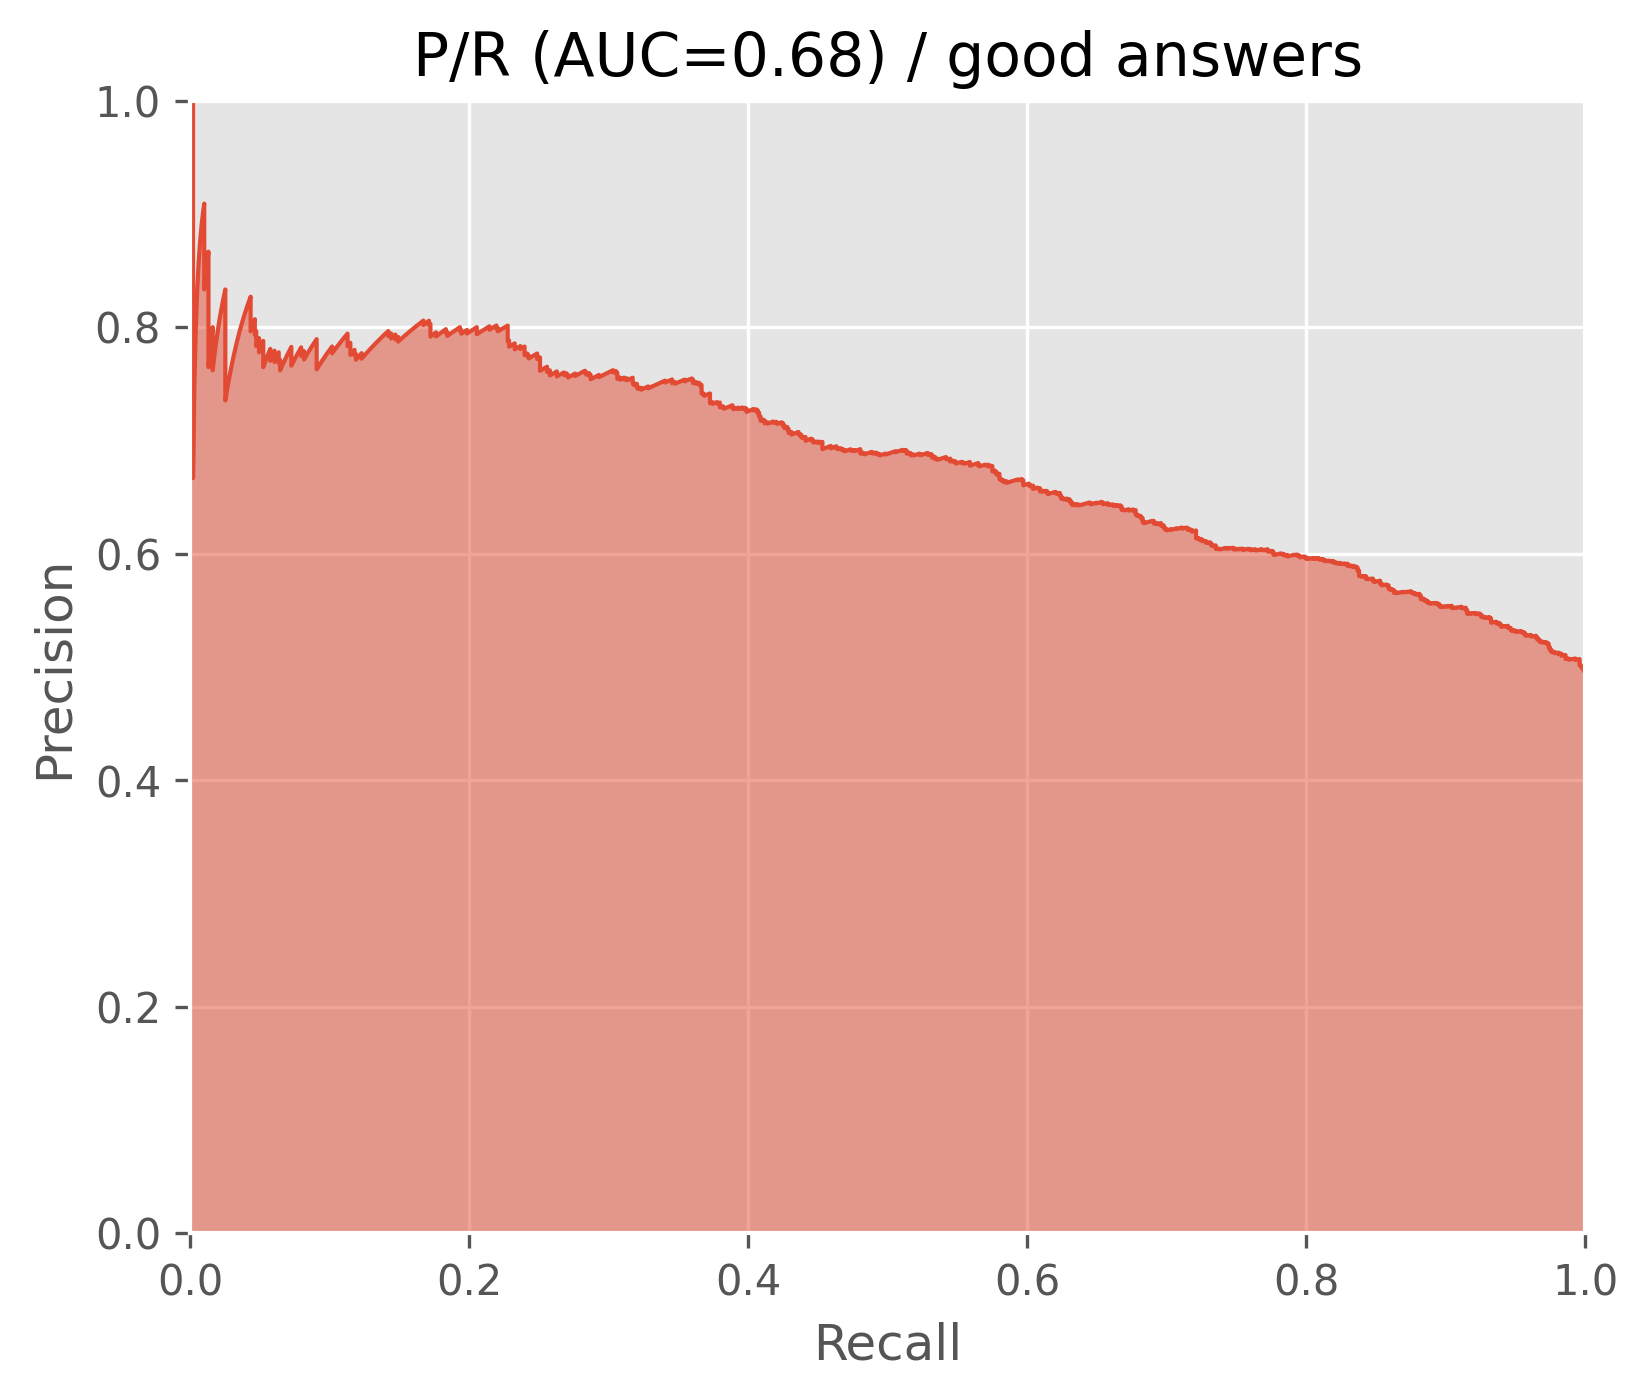

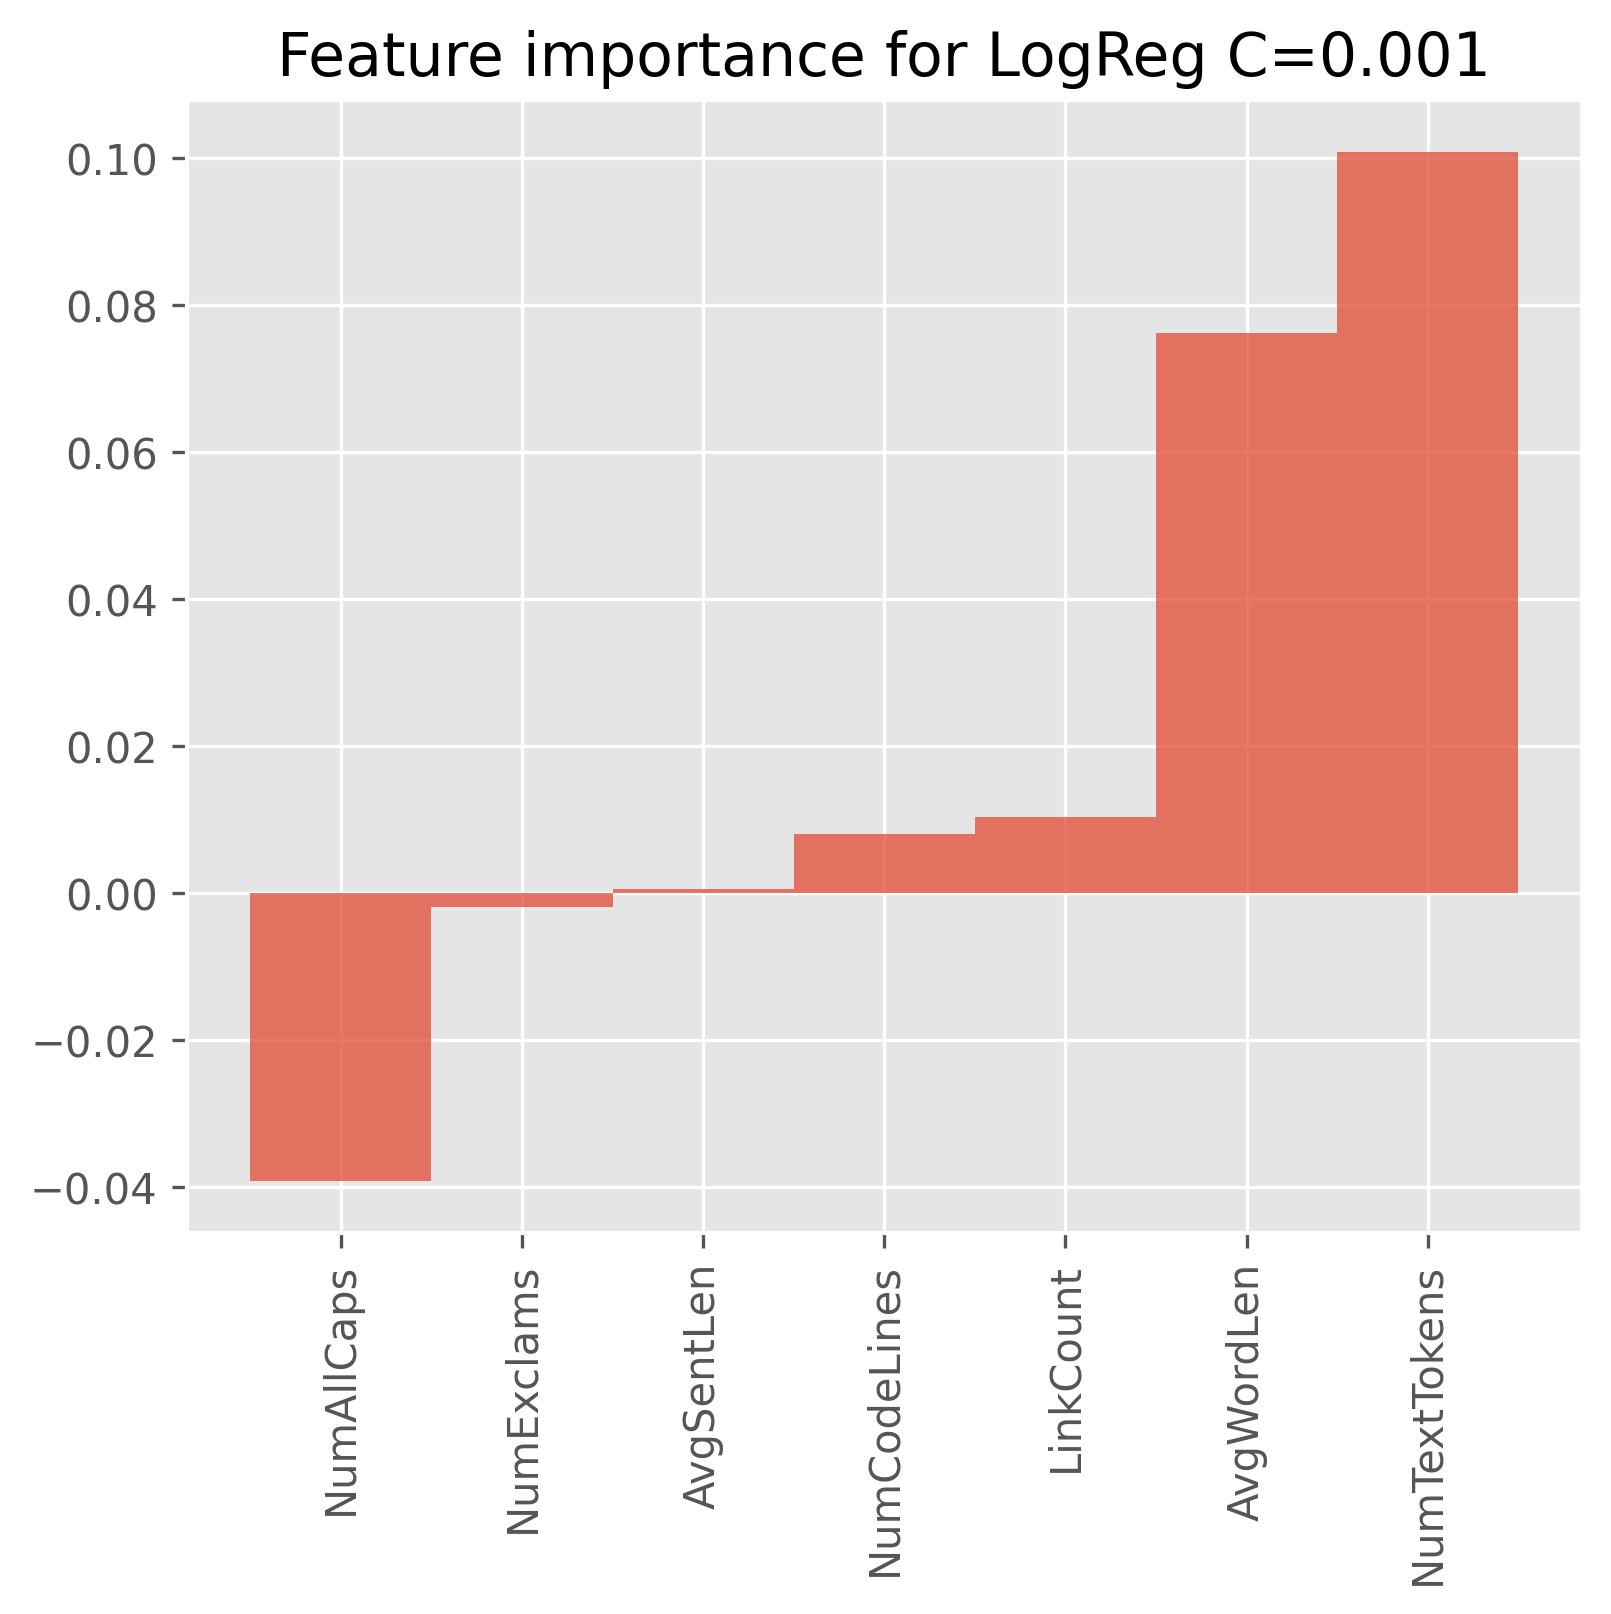

In [34]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = f"LogReg C={C_best}"

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


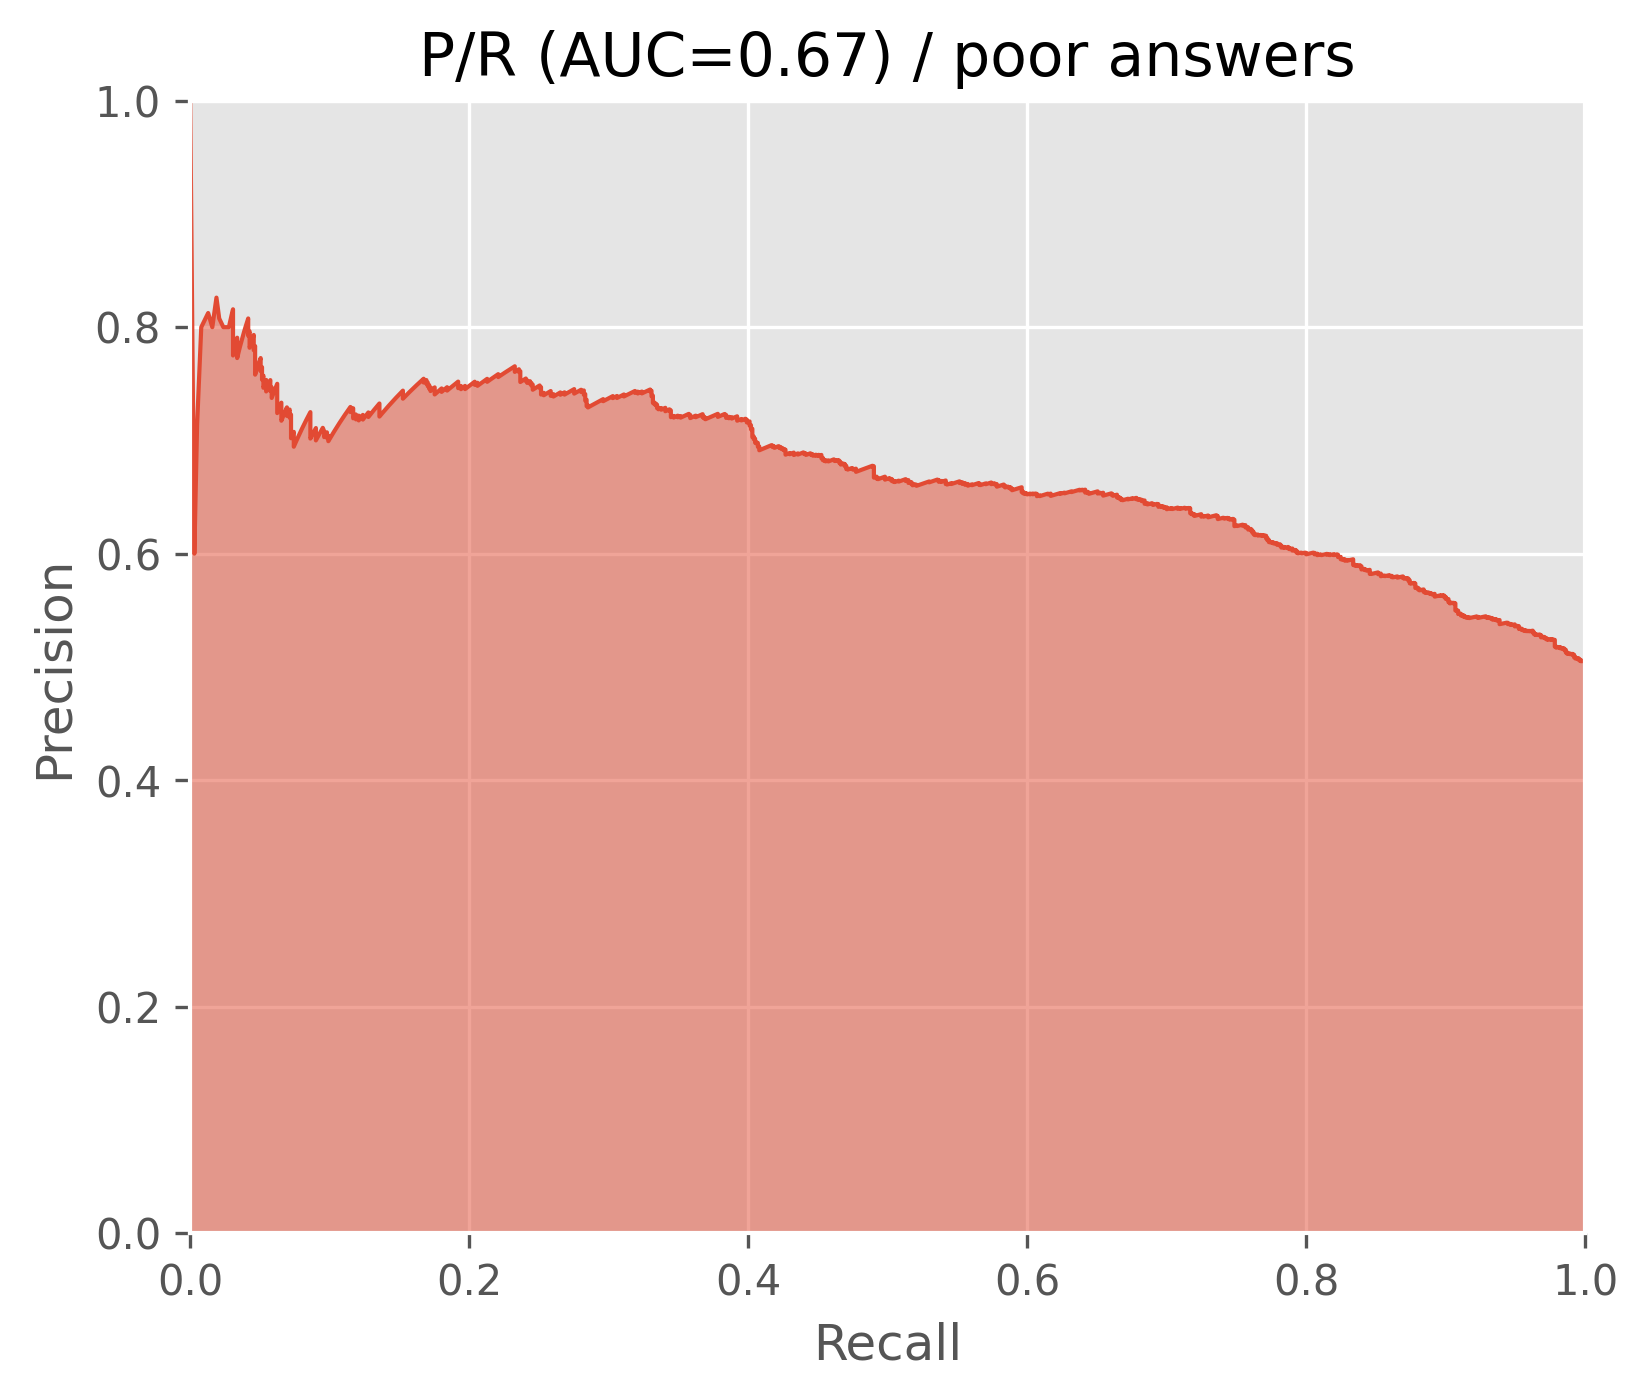

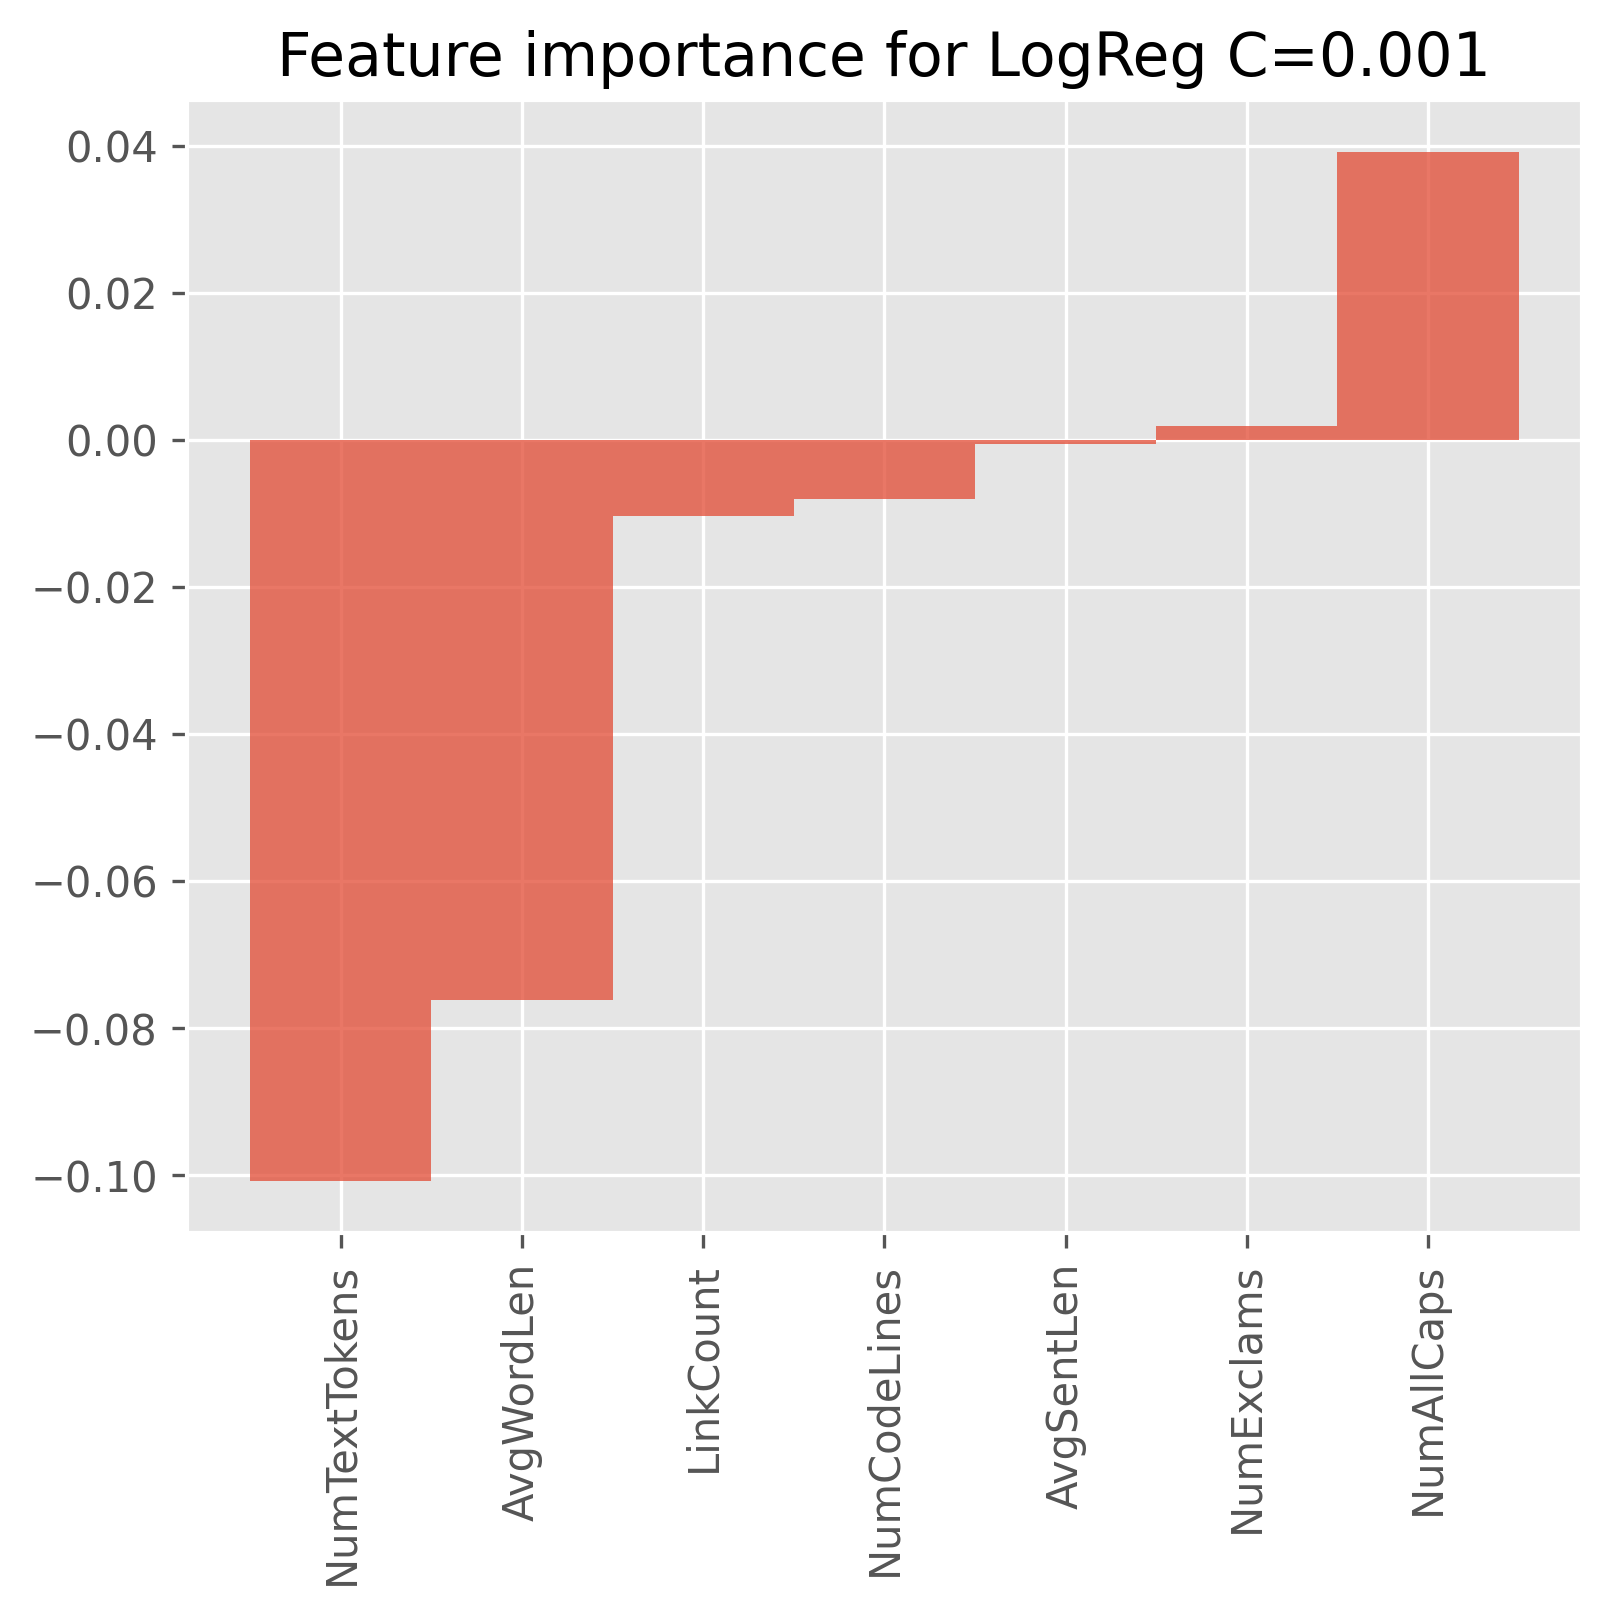

In [35]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

In [36]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))

P=0.77 R=0.25 thresh=0.62
P=0.78 R=0.24 thresh=0.63
P=0.79 R=0.23 thresh=0.64
P=0.80 R=0.23 thresh=0.64


In [37]:
good_thresh = 0.66

### Ship it!

In [38]:
clf = LogisticRegression(C=C_best)
clf.fit(X, Y)
print(clf.coef_)

[[ 0.11503621  0.00777127  0.01019613  0.00074361  0.07100775 -0.03964712
  -0.00768253]]


/home/shreyam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
import pickle
pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_)

[[ 0.11503621  0.00777127  0.01019613  0.00074361  0.07100775 -0.03964712
  -0.00768253]]


We can now use the classifier's `predict_proba()` to calculate the probabilities for the classes `poor` and `good`:

In [40]:
# Remember that the features are in this order:
# LinkCount, NumCodeLines, NumTextTokens, AvgSentLen, AvgWordLen, NumAllCaps, NumExclams
good_post = (2, 1, 100, 5, 4, 1, 0)
poor_post = (1, 0, 10, 5, 6, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
proba

array([[0.35691616, 0.64308384],
       [0.62222157, 0.37777843]])

In [41]:
proba >= good_thresh

array([[False, False],
       [False, False]])

### Classification with Tensorflow

In [52]:
import tensorflow.compat.v1 as tf

In [53]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

In [54]:
Y = Y.astype(np.float32)[:, None]
bce_ceil = 1e-5
Y = Y * (1 - 2 * bce_ceil) + bce_ceil

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

In [56]:
def create_dense(x, n_units, name, alpha=0.2):
    # Hidden layer
    h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
    return h

def create_output(x):
    # Output layer
    h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")
    return h

In [57]:
tf.reset_default_graph()

n_epochs = 500
batch_size = 1000
steps = 10
layer1_size = 5

In [59]:
# disabling eager mode
tf.compat.v1.disable_eager_execution()

X_tf = tf.placeholder(tf.float32, (None, 7), name="Input")
Y_ref_tf = tf.placeholder(tf.float32, (None, 1), name="Target_output")

h1 = create_dense(X_tf, layer1_size, name="Layer1")
Y_tf = create_output(h1)

loss = tf.reduce_mean(tf.square(Y_ref_tf - Y_tf))

grad_speed = .01
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

/tmp/ipykernel_3726/1831555830.py:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
/tmp/ipykernel_3726/1831555830.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")


Training session

In [60]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_vec = []
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(X_train))
        for j in range(0, len(X_train), batch_size):
            batch = permut[j:j+batch_size]
            Xs = X_train[batch]
            Ys = Y_train[batch]
            
            sess.run(train_step, feed_dict={X_tf: Xs, Y_ref_tf: Ys})
        
        temp_loss = sess.run(loss, feed_dict={X_tf: X_train, Y_ref_tf: Y_train})
        loss_vec.append(temp_loss)
        if epoch % steps == steps - 1:
            print('Epoch #%i  loss = %s' % (epoch, temp_loss))

    predict_train = sess.run(Y_tf, feed_dict={X_tf: X_train})
    predict_test = sess.run(Y_tf, feed_dict={X_tf: X_test})

2022-08-19 08:23:06.333102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-19 08:23:06.333170: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-19 08:23:06.349586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archpc): /proc/driver/nvidia/version does not exist
2022-08-19 08:23:06.681184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch #9  loss = 0.5009873
Epoch #19  loss = 0.5009658
Epoch #29  loss = 0.5009427
Epoch #39  loss = 0.50091827
Epoch #49  loss = 0.5008926
Epoch #59  loss = 0.50086683
Epoch #69  loss = 0.50084096
Epoch #79  loss = 0.500814
Epoch #89  loss = 0.50078577
Epoch #99  loss = 0.5007565
Epoch #109  loss = 0.5007266
Epoch #119  loss = 0.5006961
Epoch #129  loss = 0.50066596
Epoch #139  loss = 0.50063556
Epoch #149  loss = 0.50060505
Epoch #159  loss = 0.5005742
Epoch #169  loss = 0.5005426
Epoch #179  loss = 0.50050956
Epoch #189  loss = 0.5004751
Epoch #199  loss = 0.50044066
Epoch #209  loss = 0.50040567
Epoch #219  loss = 0.5003675
Epoch #229  loss = 0.5003264
Epoch #239  loss = 0.5002812
Epoch #249  loss = 0.50023425
Epoch #259  loss = 0.5001824
Epoch #269  loss = 0.500124
Epoch #279  loss = 0.5000593
Epoch #289  loss = 0.4999806
Epoch #299  loss = 0.49988344
Epoch #309  loss = 0.49976268
Epoch #319  loss = 0.4995998
Epoch #329  loss = 0.49936107
Epoch #339  loss = 0.49897745
Epoch #349  

Text(0, 0.5, 'Loss')

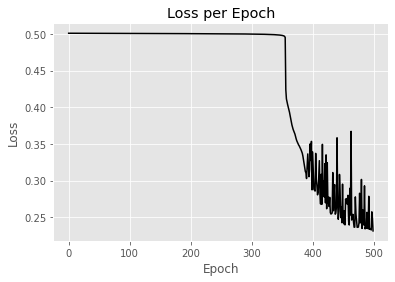

In [62]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [63]:
from sklearn.metrics import accuracy_score

score = accuracy_score(Y_train > .5, predict_train > .5)
print("Score (on training data): %.2f" % score)
score = accuracy_score(Y_test > .5, predict_test > .5)
print("Score (on testing data): %.2f" % score)

Score (on training data): 0.64
Score (on testing data): 0.64


In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

        Poor       0.62      0.69      0.66      7968
        Good       0.66      0.58      0.62      8032

    accuracy                           0.64     16000
   macro avg       0.64      0.64      0.64     16000
weighted avg       0.64      0.64      0.64     16000

Confusion matrix, without normalization
[[5531 2437]
 [3334 4698]]


/tmp/ipykernel_3726/3172537553.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


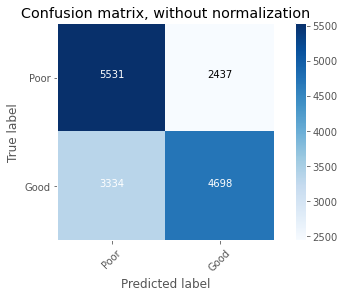

              precision    recall  f1-score   support

        Poor       0.63      0.69      0.66      2032
        Good       0.64      0.59      0.61      1968

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000

Confusion matrix, without normalization
[[1393  639]
 [ 813 1155]]


/tmp/ipykernel_3726/3172537553.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


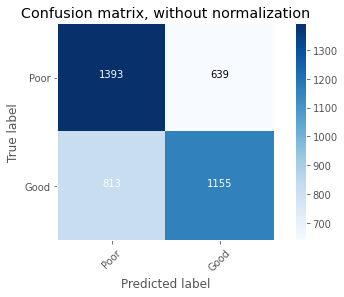

In [67]:
class_names = ["Poor", "Good"]
from sklearn import metrics
print(metrics.classification_report(Y_train > .5, predict_train > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_train > .5, predict_train > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
plt.show()
print(metrics.classification_report(Y_test > .5, predict_test > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_test > .5, predict_test > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
plt.show()